In [1]:
%%capture
!pip install geopandas

In [2]:
%%capture
!pip install geodatasets

In [3]:
%%capture
!pip install pycountry

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import geopandas as gpd
import geodatasets
import matplotlib.patches as mpatches
import pycountry
import re
from google.colab import files

In [5]:
def load_data(filename):
    df = pd.read_csv(filename)
    return df

In [6]:
def display_data_info(df):
    df.info()
    print(df.describe())

In [7]:
def datasets_1(filename):
    df = load_data(filename)
    display_data_info(df)

    return df

In [8]:
tiff_2024 = datasets_1('TIFF_Festival_2024.csv')
tiff_2022 = datasets_1('TIFF_Festival_2022.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 954 entries, 0 to 953
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Title                954 non-null    object 
 1   Venue                954 non-null    object 
 2   Room                 954 non-null    object 
 3   Date                 954 non-null    object 
 4   Start Time           954 non-null    object 
 5   End Date             954 non-null    object 
 6   End Time             954 non-null    object 
 7   Priority/Premium     954 non-null    object 
 8   Audience Type        954 non-null    object 
 9   Extended Q&A         954 non-null    object 
 10  Countries            922 non-null    object 
 11  Languages            912 non-null    object 
 12  Programme or Series  954 non-null    object 
 13  Directors            922 non-null    object 
 14  Region Availability  0 non-null      float64
dtypes: float64(1), object(14)
memory usage: 

In [9]:
# Columns in dataset
tiff_2024.columns

Index(['Title', 'Venue', 'Room', 'Date', 'Start Time', 'End Date', 'End Time',
       'Priority/Premium', 'Audience Type', 'Extended Q&A', 'Countries',
       'Languages', 'Programme or Series', 'Directors', 'Region Availability'],
      dtype='object')

In [10]:
# Columns in dataset
tiff_2022.columns

Index(['Title', 'Venue', 'Room', 'Date', 'Start Time', 'End Date', 'End Time',
       'Priority/Premium', 'Audience Type', 'Extended Q&A', 'Countries',
       'Languages', 'Programme or Series', 'Directors', 'Region Availability'],
      dtype='object')

In [11]:
tiff_2024.head()

Title                       Venue             Room  \
0  100 Litres of Gold  Scotiabank Theatre Toronto     Scotiabank 5   
1            40 Acres               TIFF Lightbox  TIFF Lightbox 1   
2            40 Acres  Scotiabank Theatre Toronto    Scotiabank 10   
3            40 Acres  Scotiabank Theatre Toronto     Scotiabank 1   
4            40 Acres  Scotiabank Theatre Toronto     Scotiabank 3   

         Date Start Time    End Date End Time Priority/Premium  \
0  Sat Sep 07      12:10  Sat Sep 07    13:38               No   
1  Fri Sep 06      21:00  Fri Sep 06    23:18               No   
2  Sat Sep 07      09:15  Sat Sep 07    11:03               No   
3  Sat Sep 07      21:00  Sat Sep 07    23:18               No   
4  Thu Sep 12      08:45  Thu Sep 12    10:33               No   

                                       Audience Type Extended Q&A  \
0  Buyers Pass,Industry Pass,Film Rep Pass,Premiu...           No   
1                                     General Public           No   
2  Buyers Pass,Industry Pass,Film Rep Pass,Premiu...           No   
3                                     General Public           No   
4  Buyers Pass,Industry Pass,Film Rep Pass,Premiu...           No   

       Countries      Languages    Programme or Series    Directors  \
0  Finland,Italy        Finnish       Market Screening  Teemu Nikki   
1         Canada  English, Cree  Special Presentations  R.T. Thorne   
2         Canada  English, Cree  Special Presentations  R.T. Thorne   
3         Canada  English, Cree  Special Presentations  R.T. Thorne   
4         Canada  English, Cree  Special Presentations  R.T. Thorne   

   Region Availability  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN

In [12]:
# Converts the specified 'Date' and 'Start Time' columns in the DataFrame to proper datetime formats

def convert_datetime_columns(df, date_col='Date', start_time_col='Start Time', year=2024):

    # Convert 'Date' to a proper datetime format
    df[date_col] = pd.to_datetime(df[date_col] + f' {year}', format='%a %b %d %Y', errors='coerce')

    # Convert 'Start Time' to a proper datetime format for comparison
    df[start_time_col] = pd.to_datetime(df[start_time_col], format='%H:%M', errors='coerce').dt.time

    return df

In [13]:
tiff_2024 = convert_datetime_columns(tiff_2024, date_col='Date', start_time_col='Start Time', year=2024)
tiff_2022 = convert_datetime_columns(tiff_2022, date_col='Date', start_time_col='Start Time', year=2022)

In [14]:
# List of specific movies as an example to how the dataset can be used
movies = ["Riff Raff", "Faithless", "All We Imagine as Light"]

# Loop through each movie to apply the filtering and condition
for movie in movies:
    # Filter the DataFrame for the specific movie
    filtered_tiff_2024 = tiff_2024[tiff_2024['Title'] == movie]

    # Define filters for screenings based on the day of the week and time
    weekday_filter = (filtered_tiff_2024['Date'].dt.day_name().isin(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday'])) & \
                     (filtered_tiff_2024['Start Time'] >= pd.to_datetime('15:00', format='%H:%M').time())
    weekend_filter = (filtered_tiff_2024['Date'].dt.day_name().isin(['Friday', 'Saturday'])) & \
                     (filtered_tiff_2024['Start Time'] >= pd.to_datetime('11:00', format='%H:%M').time())

    # Apply filters and additional conditions
    filtered_tiff_2024 = filtered_tiff_2024[weekday_filter | weekend_filter]
    filtered_tiff_2024 = filtered_tiff_2024[filtered_tiff_2024['Date'] != pd.to_datetime('2024-09-11')]
    filtered_tiff_2024 = filtered_tiff_2024[filtered_tiff_2024['Audience Type'] == 'General Public']

    # Check if any showtimes are found
    if filtered_tiff_2024.empty:
        print("\nNo showtime was found for:", movie)
    else:
        # Select relevant columns if showtimes are found
        showtimes = filtered_tiff_2024[['Title', 'Venue', 'Room', 'Date', 'Start Time', 'End Time', 'Audience Type']]
        display(showtimes)

Title                       Venue           Room       Date  \
517  Riff Raff  Scotiabank Theatre Toronto   Scotiabank 1 2024-09-13   
518  Riff Raff  Scotiabank Theatre Toronto  Scotiabank 14 2024-09-14   

    Start Time End Time   Audience Type  
517   13:00:00    15:13  General Public  
518   15:45:00    17:58  General Public

Title                       Venue          Room       Date  \
205  Faithless  Scotiabank Theatre Toronto  Scotiabank 3 2024-09-13   

    Start Time End Time   Audience Type  
205   12:00:00    13:58  General Public


No showtime was found for: All We Imagine as Light


In [15]:
# Clean and standardize language names
def clean_language(language):
    if pd.isna(language):
        return None
    language = re.sub(r'[\-\/]', ',', language)
    if ',' in language:
        return 'Multilingual'
    return language.strip().lower()

In [16]:
tiff_2024['Languages'] = tiff_2024['Languages'].apply(clean_language)

In [17]:
tiff_2022['Languages'] = tiff_2022['Languages'].apply(clean_language)

In [18]:
# Categorize languages
def categorize_language(language):
    if language in ['Chinese', 'Mandarin', 'Cantonese']:
        return 'Chinese'
    return language

In [19]:
tiff_2024['Languages'] = tiff_2024['Languages'].apply(categorize_language)
tiff_2024 = tiff_2024[tiff_2024['Languages'].notna()]
print(tiff_2024['Languages'].value_counts())

Languages
english             382
Multilingual        258
spanish              44
french               25
chinese              22
italian              17
japanese             16
korean               14
portuguese           13
arabic               12
hindi                11
vietnamese            8
farsi                 8
indonesian            8
mongolian             5
tagalog               5
bulgarian             5
bangla                4
thai                  4
danish                4
māori                 4
somali                4
russian               4
mandarin chinese      4
cantonese             4
turkish               4
georgian              4
persian               4
no dialogue           3
swedish               3
mandarin              3
manipuri              3
serbian               1
german                1
finnish               1
Name: count, dtype: int64


In [20]:
tiff_2022['Languages'] = tiff_2022['Languages'].apply(categorize_language)
tiff_2022 = tiff_2022[tiff_2022['Languages'].notna()]
print(tiff_2022['Languages'].value_counts())

Languages
english         338
Multilingual    247
french           52
spanish          46
korean           23
hindi            14
arabic           14
farsi             9
italian           8
portuguese        7
assamese          6
turkish           5
danish            5
russian           4
japanese          4
mandarin          4
indonesian        4
german            4
bosnian           4
yoruba            4
georgian          4
persian           3
Name: count, dtype: int64


In [21]:
# Clean and standardize country names in TIFF datasets
def clean_country_name(country):
    if pd.isna(country):
        return None
    country = country.strip()
    if country == 'United States of America':
        return 'United States'
    elif country == 'Sápmi (Norway/Sweden/Finland)':
        return 'Scandinavian'
    elif ',' in country:
        return 'Multi-country'
    return country

In [22]:
tiff_2024['Countries'] = tiff_2024['Countries'].apply(clean_country_name)
tiff_2022['Countries'] = tiff_2022['Countries'].apply(clean_country_name)

In [23]:
# additional mappings to handle specific cases
country_name_mapping = {
    'Korea, Republic of': 'South Korea',
    'Taiwan, Province of China': 'Taiwan',
    'Scandinavian': 'Norway',
}
tiff_2024['Countries'] = tiff_2024['Countries'].replace(country_name_mapping)
tiff_2022['Countries'] = tiff_2022['Countries'].replace(country_name_mapping)

In [24]:
# Load the world map data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Rename the 'name' column to 'Countries' to match the datasets
world = world.rename(columns={'name': 'Countries'})

<ipython-input-24-30653a9c6c9d>:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [25]:
# Standardize country names in the world map data
def standardize_country_name(country):
    try:
        return pycountry.countries.lookup(country).name
    except LookupError:
        return country

world['Countries'] = world['Countries'].apply(standardize_country_name)

Uploading World maps data

In [26]:
%%capture
# @title
import os

# List files in the current directory
os.listdir()

In [27]:

from google.colab import files

uploaded = files.upload()

In [28]:
%%capture
# @title
import os

os.listdir()

In [29]:
import geopandas as gpd

# Read the shapefile
shapefile = gpd.read_file('ne_110m_admin_0_countries.shp')

# Display the first few rows
shapefile.head()

featurecla  scalerank  LABELRANK                   SOVEREIGNT SOV_A3  \
0  Admin-0 country          1          6                         Fiji    FJI   
1  Admin-0 country          1          3  United Republic of Tanzania    TZA   
2  Admin-0 country          1          7               Western Sahara    SAH   
3  Admin-0 country          1          2                       Canada    CAN   
4  Admin-0 country          1          2     United States of America    US1   

   ADM0_DIF  LEVEL               TYPE TLC                        ADMIN  ...  \
0         0      2  Sovereign country   1                         Fiji  ...   
1         0      2  Sovereign country   1  United Republic of Tanzania  ...   
2         0      2      Indeterminate   1               Western Sahara  ...   
3         0      2  Sovereign country   1                       Canada  ...   
4         1      2            Country   1     United States of America  ...   

      FCLASS_TR     FCLASS_ID     FCLASS_PL FCLASS_GR  FCLASS_IT  \
0          None          None          None      None       None   
1          None          None          None      None       None   
2  Unrecognized  Unrecognized  Unrecognized      None       None   
3          None          None          None      None       None   
4          None          None          None      None       None   

      FCLASS_NL FCLASS_SE  FCLASS_BD FCLASS_UA  \
0          None      None       None      None   
1          None      None       None      None   
2  Unrecognized      None       None      None   
3          None      None       None      None   
4          None      None       None      None   

                                            geometry  
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  

[5 rows x 169 columns]

In [30]:
# Columns in dataset
world.columns

Index(['pop_est', 'continent', 'Countries', 'iso_a3', 'gdp_md_est',
       'geometry'],
      dtype='object')

In [31]:
# Columns in dataset
shapefile.columns

Index(['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3',
       'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN',
       ...
       'FCLASS_TR', 'FCLASS_ID', 'FCLASS_PL', 'FCLASS_GR', 'FCLASS_IT',
       'FCLASS_NL', 'FCLASS_SE', 'FCLASS_BD', 'FCLASS_UA', 'geometry'],
      dtype='object', length=169)

In [32]:
world['Countries'] = world['Countries'].apply(standardize_country_name)

In [33]:
# Merges the event data with the world map data based on the country column and drops duplicate rows

def merge_with_world_map(world_df, event_df, country_col='Countries'):
    """
    Parameters:
    world_df (pd.DataFrame): The DataFrame containing world map data.
    event_df (pd.DataFrame): The DataFrame containing event data.
    country_col (str): The name of the country column used for merging in both DataFrames. Default is 'Countries'.

    Returns:
    pd.DataFrame: The merged DataFrame with duplicates removed.
    """

    # Set the country column as the index for both DataFrames
    world_df = world_df.set_index(country_col)
    event_df = event_df.set_index(country_col)

    # Merge the event data with the world map data
    merged_df = world_df.join(event_df, how='inner')

    # Drop any duplicate rows
    merged_df = merged_df[~merged_df.index.duplicated(keep='first')]

    return merged_df

# Merge TIFF 2024 with world map data
merged_2024 = merge_with_world_map(world, tiff_2024)

# Merge TIFF 2022 with world map data
merged_2022 = merge_with_world_map(world, tiff_2022)

In [34]:
# Ensure merged DataFrames are GeoDataFrames
merged_2024 = gpd.GeoDataFrame(merged_2024, geometry=merged_2024.geometry)
merged_2022 = gpd.GeoDataFrame(merged_2022, geometry=merged_2022.geometry)

In [36]:
# Plots the distribution of events by country on a world map using GeoPandas

def plot_event_distribution_by_country(world_gdf, merged_gdf, event_column='Number of Events', title='Event Distribution by Country', cmap='OrRd'):

    """
    Parameters:
    world_gdf (gpd.GeoDataFrame): The GeoDataFrame containing world map data
    merged_gdf (gpd.GeoDataFrame): The GeoDataFrame containing merged event data
    event_column (str): The column name in 'merged_gdf' that contains the number of events. Default is 'Number of Events'
    title (str): The title of the plot. Default is 'Event Distribution by Country'
    cmap (str): The colormap to use for the plot. Default is 'OrRd'

    Returns:
    None
    """

    # Ensure that the merged DataFrame is a GeoDataFrame
    if not isinstance(merged_gdf, gpd.GeoDataFrame):
        raise TypeError("merged_gdf must be a GeoDataFrame")

    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    world_gdf.plot(ax=ax, color='lightgray', edgecolor='black')
    merged_gdf.plot(column=event_column, ax=ax, legend=True,
                    cmap=cmap, legend_kwds={'label': f"{event_column} by Country", 'orientation': "horizontal"})
    plt.title(title)
    plt.show()

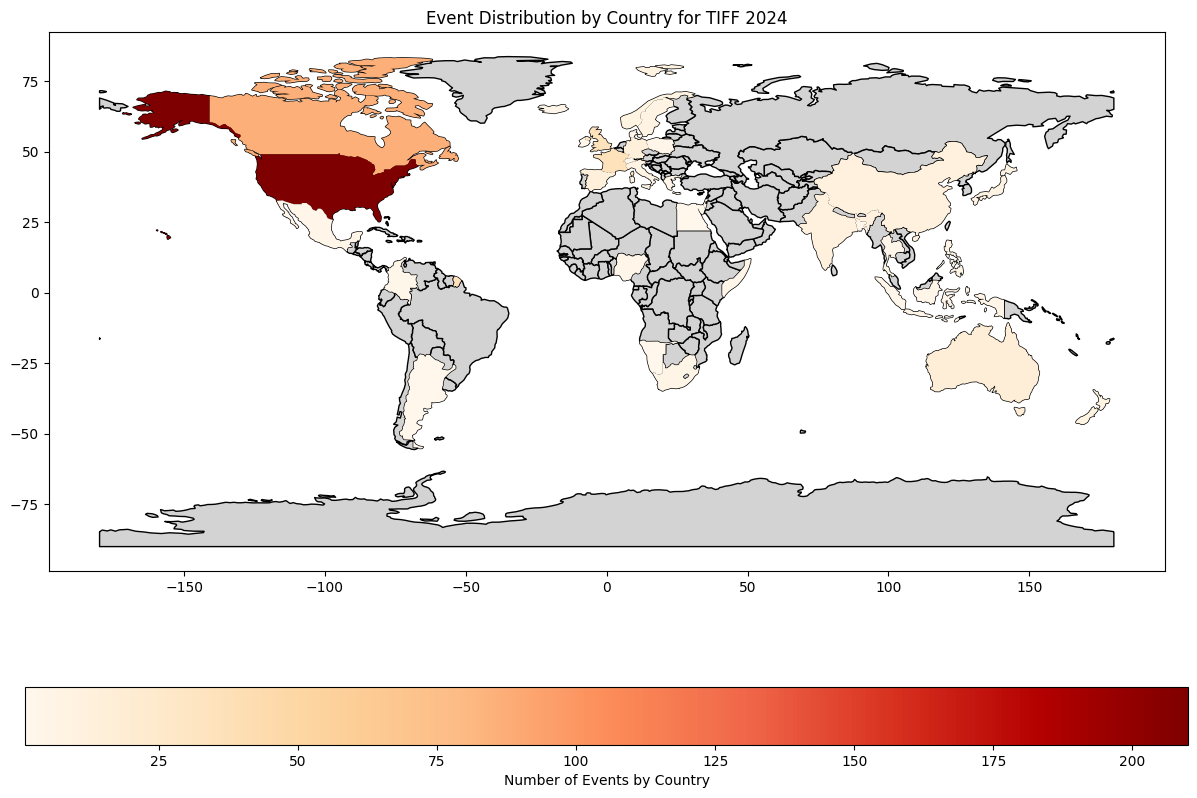

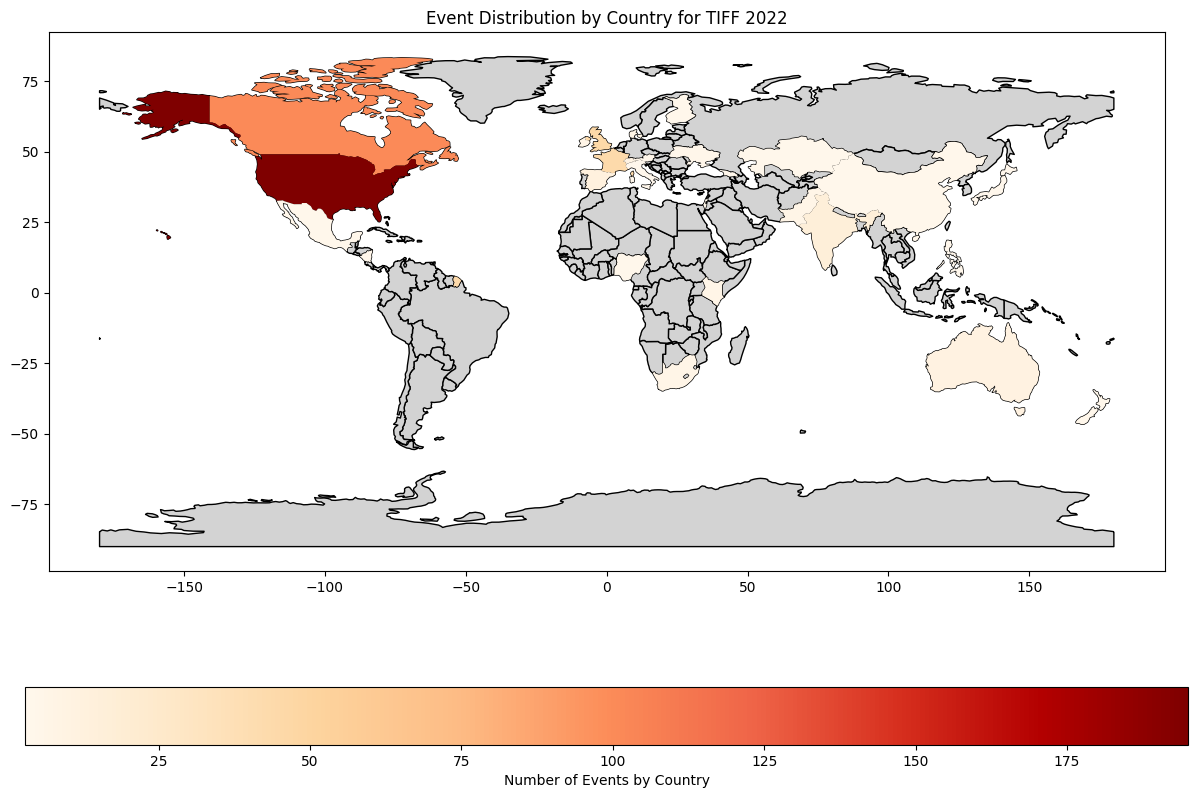

In [37]:
# For TIFF 2024
country_event_counts_2024 = tiff_2024['Countries'].value_counts().reset_index()
country_event_counts_2024.columns = ['Countries', 'Number of Events']
merged_2024 = world.set_index('Countries').join(country_event_counts_2024.set_index('Countries'))
merged_2024 = merged_2024[~merged_2024.index.duplicated(keep='first')]
plot_event_distribution_by_country(world, merged_2024, event_column='Number of Events', title='Event Distribution by Country for TIFF 2024')

# For TIFF 2022
country_event_counts_2022 = tiff_2022['Countries'].value_counts().reset_index()
country_event_counts_2022.columns = ['Countries', 'Number of Events']
merged_2022 = world.set_index('Countries').join(country_event_counts_2022.set_index('Countries'))
merged_2022 = merged_2022[~merged_2022.index.duplicated(keep='first')]
plot_event_distribution_by_country(world, merged_2022, event_column='Number of Events', title='Event Distribution by Country for TIFF 2022')

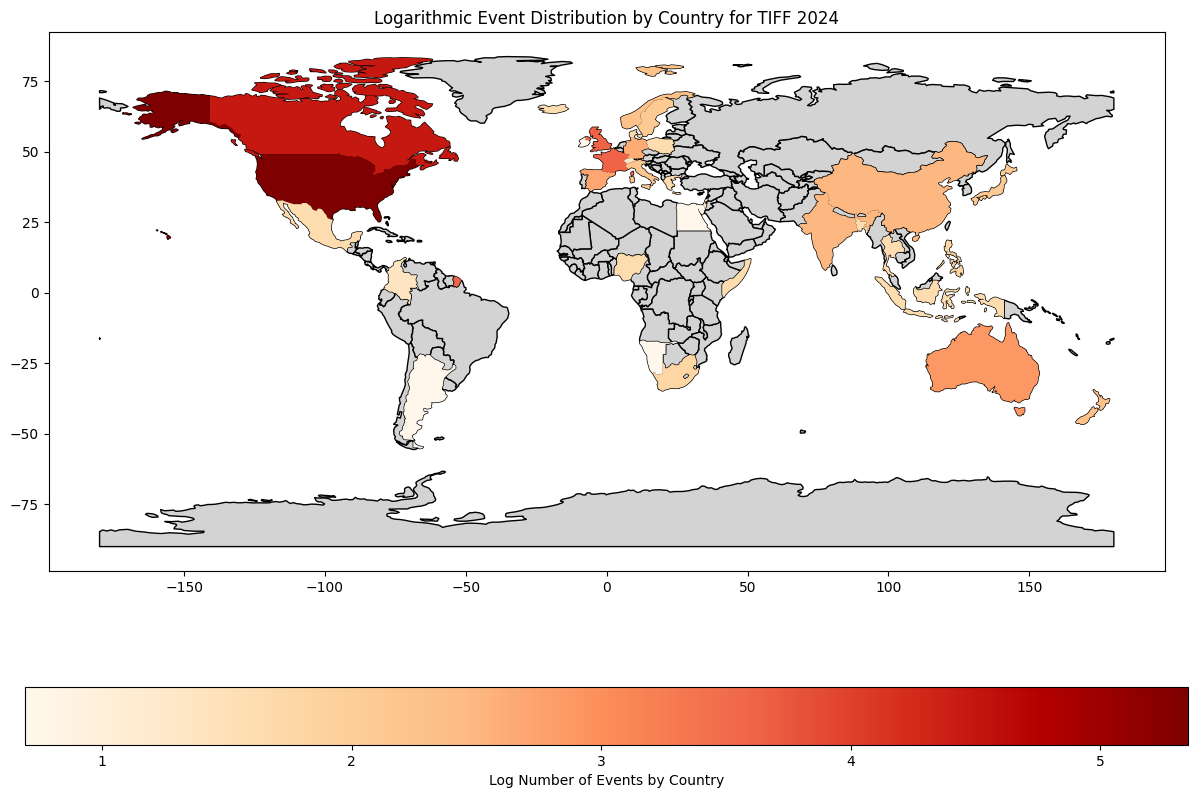

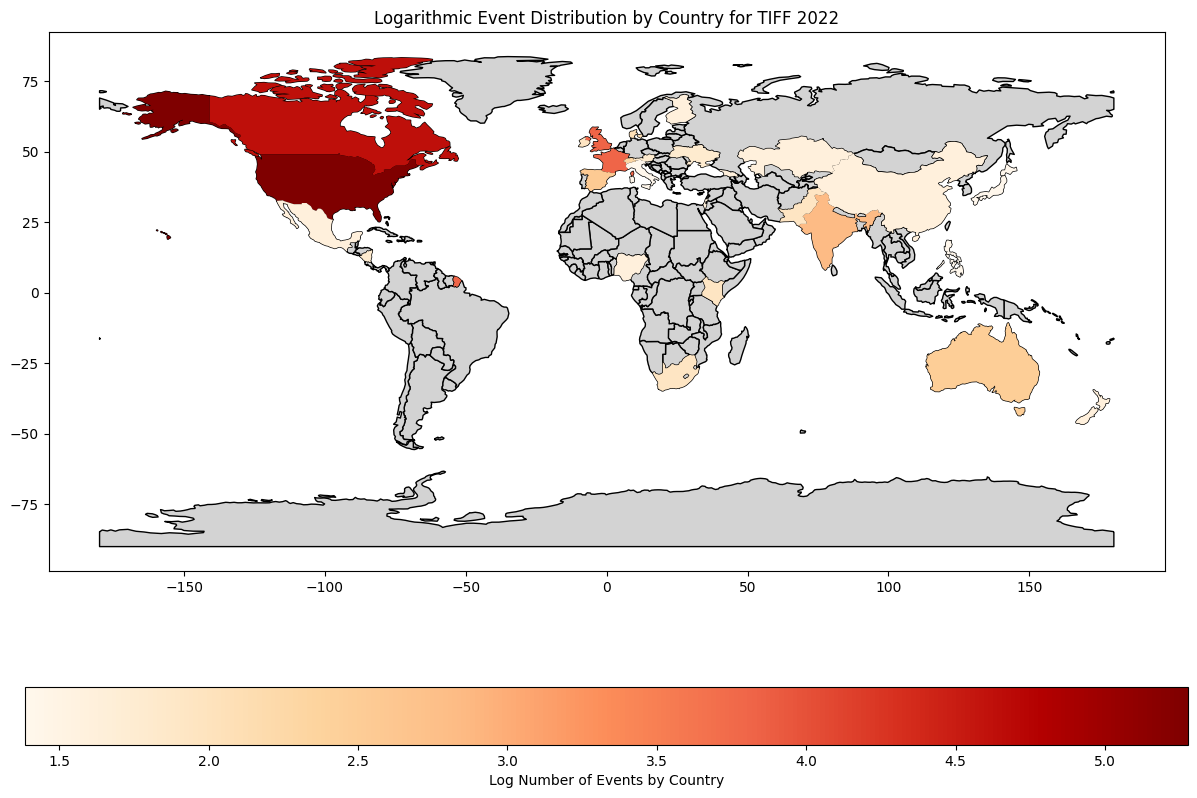

In [38]:
# Check if 'Number of Events' exists in merged_2024 and apply logarithmic transformation
if 'Number of Events' in merged_2024.columns:
    merged_2024['Log Number of Events'] = np.log1p(merged_2024['Number of Events'])
else:
    print("'Number of Events' column not found in merged_2024.")

# Check if 'Number of Events' exists in merged_2022 and apply logarithmic transformation
if 'Number of Events' in merged_2022.columns:
    merged_2022['Log Number of Events'] = np.log1p(merged_2022['Number of Events'])
else:
    print("'Number of Events' column not found in merged_2022.")

# Plotting the log-transformed data for TIFF 2024
plot_event_distribution_by_country(world, merged_2024, event_column='Log Number of Events', title='Logarithmic Event Distribution by Country for TIFF 2024')

# Plotting the log-transformed data for TIFF 2022
plot_event_distribution_by_country(world, merged_2022, event_column='Log Number of Events', title='Logarithmic Event Distribution by Country for TIFF 2022')

In [39]:
# Aggregates event data by language groups, merges with the world map, and plots the distribution

def aggregate_and_plot_language_distribution(world_df, event_df, year, cmap='OrRd'):

    """
    Parameters:
    world_df (gpd.GeoDataFrame): The GeoDataFrame containing world map data
    event_df (pd.DataFrame): The DataFrame containing event data
    year (int): The year of the TIFF festival (2024 or 2022)
    cmap (str): The colormap to use for the plot. Default is 'OrRd'

    Returns:
    None
    """

    # Aggregate data by language groups
    language_event_counts = event_df.groupby('Languages').size().reset_index(name='Number of Events by Language')
    event_df = event_df.merge(language_event_counts, on='Languages', how='left')

    # Merge with the world map data
    merged_language = world_df.set_index('Countries').join(event_df.set_index('Countries'))

    # Plot the data by language groups
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    world_df.plot(ax=ax, color='lightgray', edgecolor='black')
    merged_language.plot(column='Number of Events by Language', ax=ax, legend=True,
                         cmap=cmap, legend_kwds={'label': "Number of Events by Language Group", 'orientation': "horizontal"})
    plt.title(f'Event Distribution by Language Group for TIFF {year}')
    plt.show()

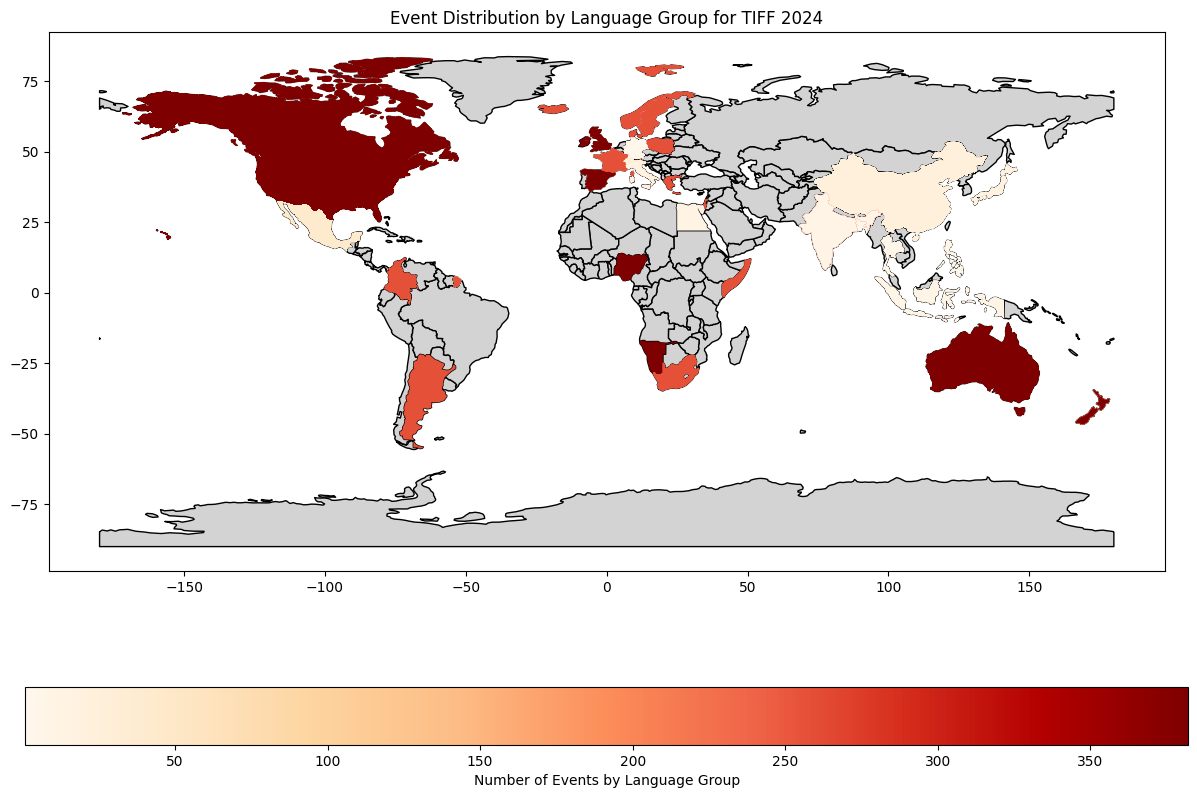

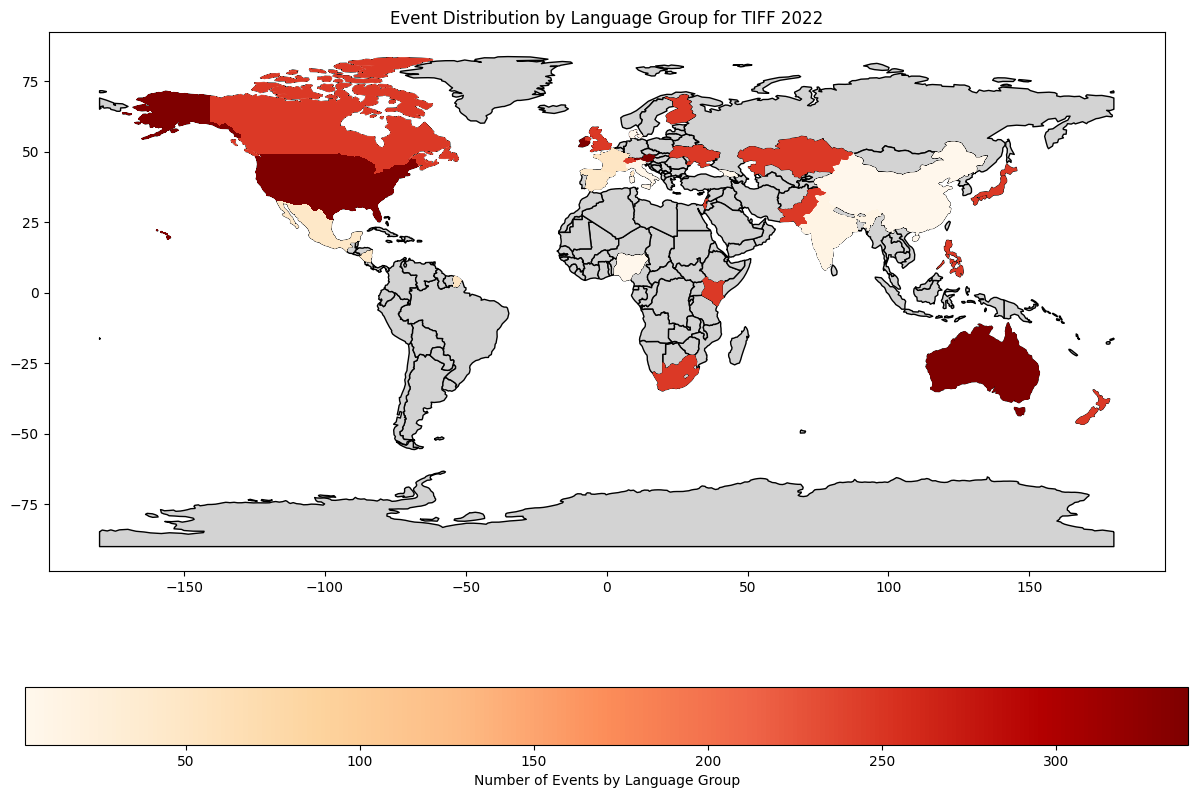

In [40]:
# Apply the function to TIFF 2024
aggregate_and_plot_language_distribution(world, tiff_2024, year=2024)

# Apply the function to TIFF 2022
aggregate_and_plot_language_distribution(world, tiff_2022, year=2022)

In [41]:
# Maps languages to their respective language groups and filters out rows with 'Other' or NaN values

def map_language_groups(df, language_group_mapping):

    """
    Parameters:
    df (pd.DataFrame): The DataFrame containing the 'Languages' column
    language_group_mapping (dict): The dictionary mapping languages to language groups

    Returns:
    pd.DataFrame: The filtered DataFrame with a new 'Language Group' column
    """
    # Applying the mapping to create a new 'Language Group' column
    df['Language Group'] = df['Languages'].map(lambda x: language_group_mapping.get(x, 'Other'))

    # Remove empty rows and those categorized as 'Other'
    df = df.dropna(subset=['Countries', 'Languages', 'Language Group'])
    df = df[df['Language Group'] != 'Other']

    return df

In [42]:
# Aggregates event data by language groups and merges with the world map data

def aggregate_and_merge_language_groups(world_df, event_df):

    """
    Parameters:
    world_df (gpd.GeoDataFrame): The GeoDataFrame containing world map data
    event_df (pd.DataFrame): The DataFrame containing event data

    Returns:
    gpd.GeoDataFrame: The merged GeoDataFrame with aggregated language group data
    """
    # Aggregation
    language_group_counts = event_df.groupby('Language Group').size().reset_index(name='Number of Events by Language Group')
    event_df = event_df.merge(language_group_counts, on='Language Group', how='left')

    # Merge with the world map data using the standardized 'Countries' column
    merged_language_group = world_df.set_index('Countries').join(event_df.set_index('Countries'))

    return merged_language_group

In [43]:
# Plots the distribution of events by language groups on a world map

def plot_language_distribution(merged_language_group, world_df, title='Event Distribution by Language Group'):

    """
    Parameters:
    merged_language_group (gpd.GeoDataFrame): The merged GeoDataFrame with language group data
    world_df (gpd.GeoDataFrame): The GeoDataFrame containing world map data
    title (str): The title of the plot. Default is 'Event Distribution by Language Group'

    Returns:
    None
    """
    # Plotting the data by language groups
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    world_df.plot(ax=ax, color='lightgray', edgecolor='black')

    unique_groups = merged_language_group['Language Group'].dropna().unique()
    cmap = plt.cm.get_cmap('tab20', len(unique_groups))
    color_mapping = dict(zip(unique_groups, cmap.colors))

    for idx, row in merged_language_group.dropna(subset=['Number of Events by Language Group']).iterrows():
        ax.scatter(row['geometry'].centroid.x, row['geometry'].centroid.y,
                   s=row['Number of Events by Language Group'] * 10,
                   color=color_mapping[row['Language Group']],
                   alpha=0.6, edgecolor='k', zorder=2)

    legend_labels = [mpatches.Patch(color=color_mapping[group], label=group) for group in unique_groups]
    plt.legend(handles=legend_labels, title="Language Group", bbox_to_anchor=(1, 1))

    plt.title(title)
    plt.show()

In [44]:
# Define the language group mapping

language_group_mapping = {
    'english': 'English',
    'french': 'French',
    'spanish': 'Spanish',
    'portuguese': 'Portuguese',
    'italian': 'Italian',
    'japanese': 'Japanese',
    'korean': 'Korean',
    'german': 'German',
    'greek': 'Greek',
    'dutch': 'Dutch',
    'swedish': 'Scandinavian',
    'norwegian': 'Scandinavian',
    'danish': 'Scandinavian',
    'chinese': 'Chinese',
    'mandarin': 'Chinese',
    'cantonese': 'Chinese',
    'arabic': 'Arabic',
    'hindi': 'Indic',
    'bengali': 'Indic',
    'urdu': 'Indic',
    'russian': 'Slavic',
    'polish': 'Slavic',
    'ukrainian': 'Ukrainian',
    'hebrew': 'Hebrew',
    'turkish': 'Turkish',
    'thai': 'Thai',
    'vietnamese': 'Vietnamese',
    'indonesian': 'Indonesian',
    'multilingual': 'Multilingual'
}


In [45]:
# Apply the mapping and cleaning function to both datasets
tiff_2024 = map_language_groups(tiff_2024, language_group_mapping)
tiff_2022 = map_language_groups(tiff_2022, language_group_mapping)

In [46]:
# Aggregate data and merge with world map for both datasets
merged_language_group_2024 = aggregate_and_merge_language_groups(world, tiff_2024)
merged_language_group_2022 = aggregate_and_merge_language_groups(world, tiff_2022)

<ipython-input-43-64c3b7cd6cad>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_groups))


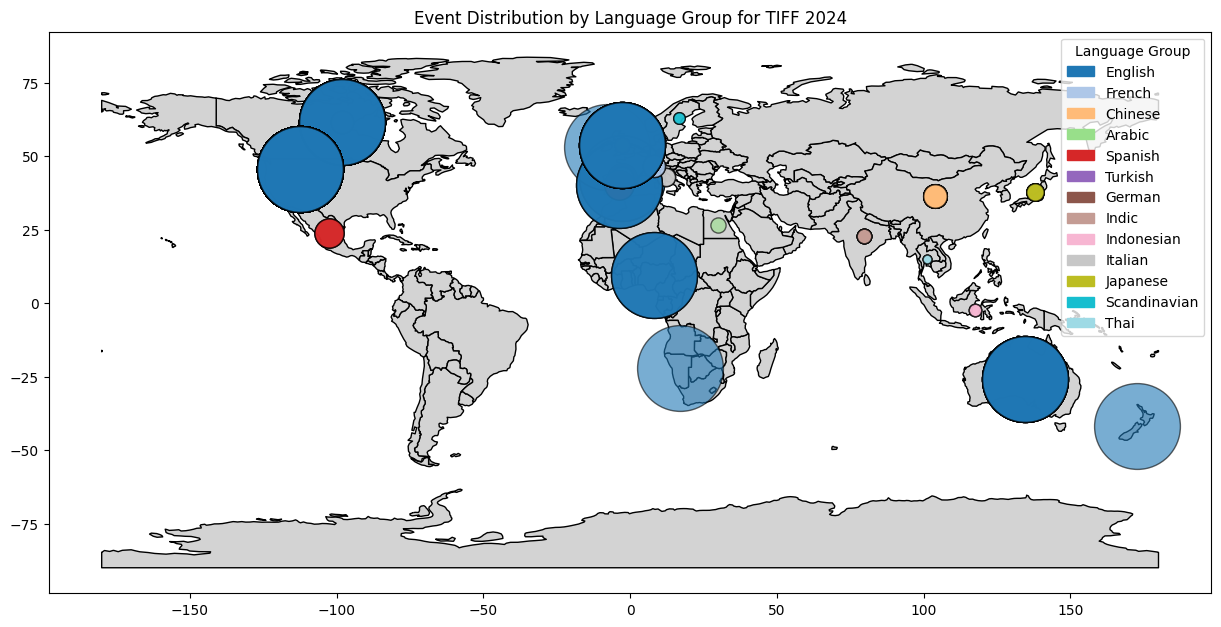

<ipython-input-43-64c3b7cd6cad>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_groups))


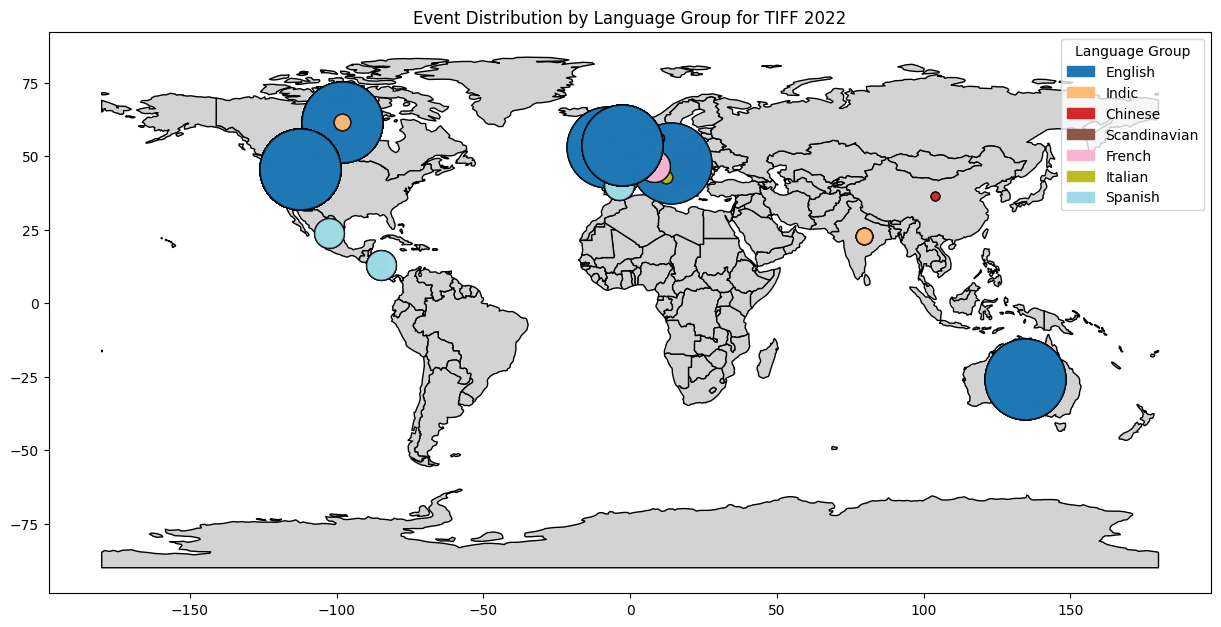

In [47]:
# Plot the data for both datasets
plot_language_distribution(merged_language_group_2024, world, title='Event Distribution by Language Group for TIFF 2024')
plot_language_distribution(merged_language_group_2022, world, title='Event Distribution by Language Group for TIFF 2022')

In [48]:
# Plots the distribution of events by language group on a world map using sorted data

def plot_sorted_language_distribution(merged_language_group, world, title):

    """
    Parameters:
    - merged_language_group (GeoDataFrame): Merged GeoDataFrame containing event data by language group
    - world (GeoDataFrame): GeoDataFrame containing the world map data
    - title (str): The title for the plot

    Returns:
    None
    """
    plt.ioff()  # Turn off interactive mode to prevent flashing

    # Sorting the merged_language_group DataFrame by 'Number of Events by Language Group' in descending order
    sorted_data = merged_language_group.dropna(subset=['Number of Events by Language Group']).sort_values(by='Number of Events by Language Group', ascending=False)

    # Plotting the data by language groups
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    world.plot(ax=ax, color='lightgray', edgecolor='black')

    # Get unique language groups
    unique_groups = sorted_data['Language Group'].dropna().unique()

    # Use the updated colormap method
    cmap = plt.colormaps['tab20']
    color_mapping = dict(zip(unique_groups, cmap(np.linspace(0, 1, len(unique_groups)))))

    # Iterating over the sorted data to plot circles
    for idx, row in sorted_data.iterrows():
        ax.scatter(row['geometry'].centroid.x, row['geometry'].centroid.y,
                   s=row['Number of Events by Language Group'] * 10,
                   color=color_mapping[row['Language Group']],
                   alpha=0.2, edgecolor='k', zorder=2)

    # Creating a legend
    legend_labels = [mpatches.Patch(color=color_mapping[group], label=group) for group in unique_groups]
    plt.legend(handles=legend_labels, title="Language Group", bbox_to_anchor=(1, 1))

    plt.title(title)
    plt.show()

# Clear previous plots
plt.clf()

<Figure size 640x480 with 0 Axes>

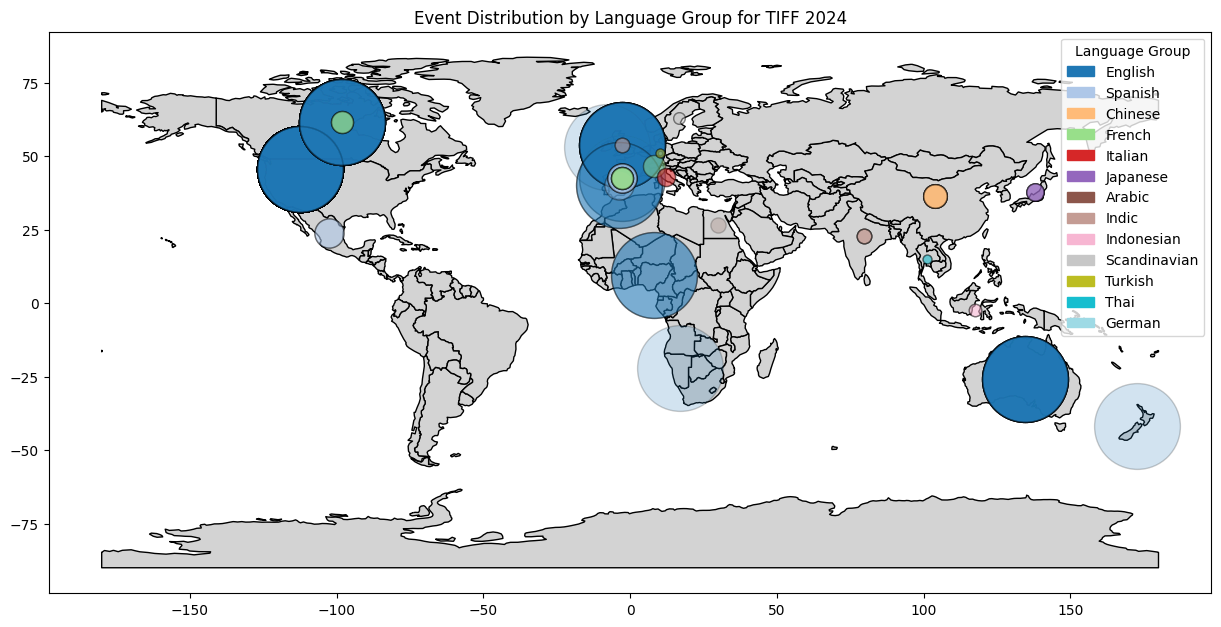

<Figure size 640x480 with 0 Axes>

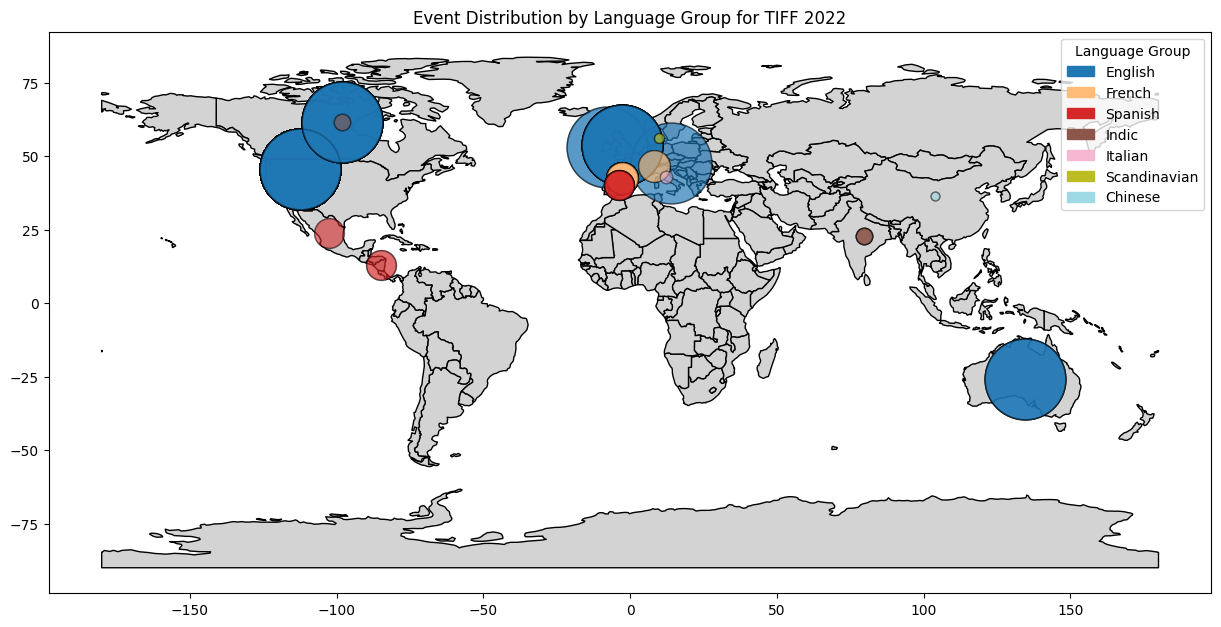

In [49]:
# Apply to TIFF 2024
plot_sorted_language_distribution(merged_language_group_2024, world, title='Event Distribution by Language Group for TIFF 2024')

# Clear the plot before plotting again
plt.clf()

# Apply to TIFF 2022
plot_sorted_language_distribution(merged_language_group_2022, world, title='Event Distribution by Language Group for TIFF 2022')

plt.close()  # Close the plot to avoid flashing

In [50]:
def plot_language_distribution(sorted_data, world, title):

    """
    Parameters:
    - sorted_data (GeoDataFrame): Sorted GeoDataFrame containing event data by language group.
    - world (GeoDataFrame): GeoDataFrame containing the world map data.
    - title (str): The title for the plot.

    Returns:
    None
    """
    # Drop rows where 'Language Group' is NaN
    sorted_data = sorted_data.dropna(subset=['Language Group'])

    # Create a single plot
    fig, ax = plt.subplots(figsize=(15, 10))
    world.plot(ax=ax, color='lightgray', edgecolor='black')

    unique_groups = sorted_data['Language Group'].dropna().unique()

    # Use the updated colormap method
    cmap = plt.colormaps.get('Set1')
    color_mapping = dict(zip(unique_groups, cmap(np.linspace(0, 1, len(unique_groups)))))

    # Iterating over the sorted data to plot circles
    for idx, row in sorted_data.iterrows():
        ax.scatter(row['geometry'].centroid.x, row['geometry'].centroid.y,
                   s=row['Number of Events by Language Group'] * 10,
                   color=color_mapping[row['Language Group']],
                   alpha=0.2, edgecolor='k', zorder=2)

    # Creating a legend
    legend_labels = [mpatches.Patch(color=color_mapping[group], label=group) for group in unique_groups]
    plt.legend(handles=legend_labels, title="Language Group", bbox_to_anchor=(1, 1))

    plt.title(title)
    plt.show()

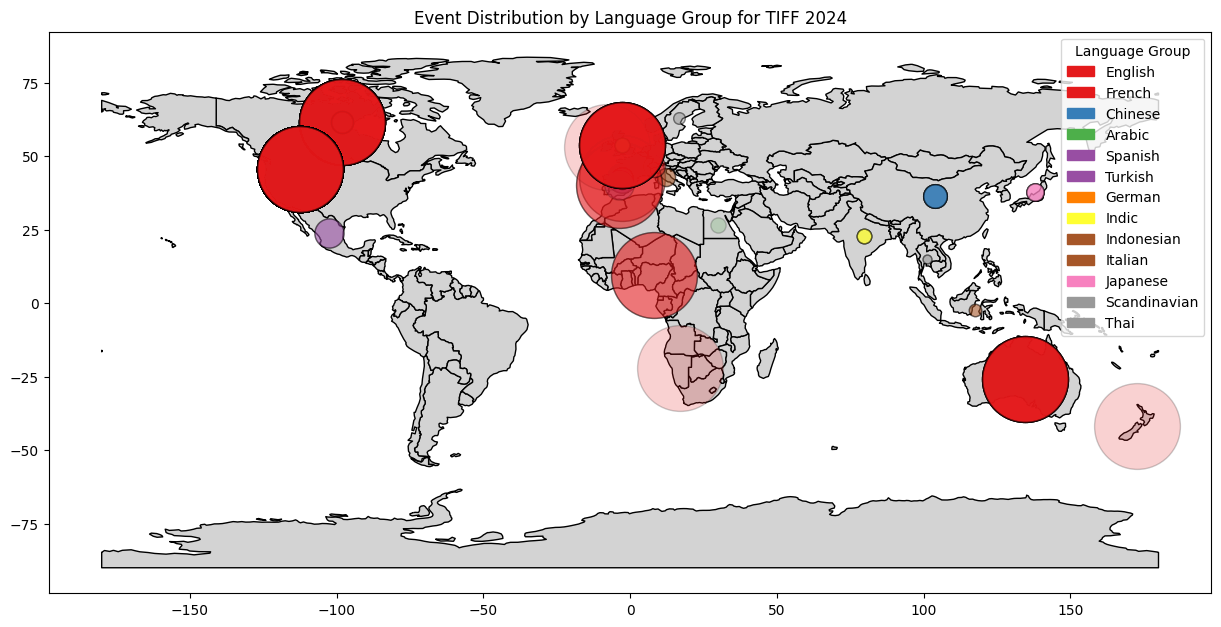

<Figure size 640x480 with 0 Axes>

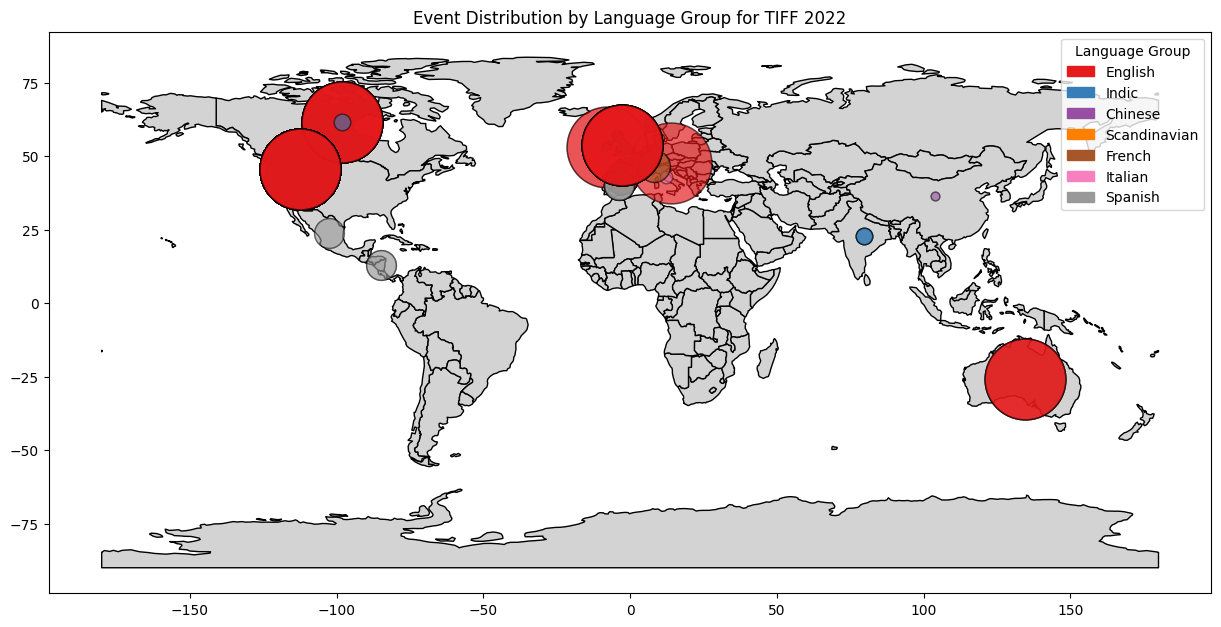

In [51]:
# Plot for TIFF 2024
plot_language_distribution(merged_language_group_2024, world, title='Event Distribution by Language Group for TIFF 2024')

# Clear the plot before plotting again
plt.clf()

# Plot for TIFF 2022
plot_language_distribution(merged_language_group_2022, world, title='Event Distribution by Language Group for TIFF 2022')

plt.close()  # Close the plot to avoid flashing

In [52]:
# Plots the distribution of events by language group on a world map using the provided data and custom colors.

def plot_language_distribution_with_custom_colors(sorted_data, world, title, alpha=0.6):

    """
    Parameters:
    - sorted_data (GeoDataFrame): Sorted GeoDataFrame containing event data by language group.
    - world (GeoDataFrame): GeoDataFrame containing the world map data.
    - title (str): The title for the plot.
    - alpha (float): The transparency level for the circles.

    Returns:
    None
    """
    # Remove rows with NaN in 'Language Group'
    sorted_data = sorted_data.dropna(subset=['Language Group'])

    # Define the custom color mapping
    custom_colors = {
        'English': '#1f77b4',      # Blue
        'Spanish': '#ff7f0e',      # Orange
        'Chinese': '#d62728',      # Red
        'French': '#2ca02c',       # Green
        'Italian': '#9467bd',      # Purple
        'Japanese': '#8c564b',     # Brown
        'Arabic': '#e377c2',       # Pink
        'Scandinavian': '#17becf', # Teal
        'Thai': '#bcbd22',         # Olive
        'German': '#7f7f7f',       # Grey
        'Indic': '#ffbb78',        # Light Orange
        'Indonesian': '#98df8a',   # Light Green
        'Turkish': '#ff9896',      # Light Red
    }

    # Assign default colors if a language group is not in the custom_colors
    color_mapping = {group: custom_colors.get(group, '#7f7f7f') for group in sorted_data['Language Group'].unique()}

    # Sort by the 'Number of Events by Language Group' to plot smaller circles last
    sorted_data = sorted_data.sort_values(by='Number of Events by Language Group', ascending=False)

    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 10))
    world.plot(ax=ax, color='lightgray', edgecolor='black')

    # Iterate over the sorted data to plot circles
    for idx, row in sorted_data.iterrows():
        ax.scatter(row['geometry'].centroid.x, row['geometry'].centroid.y,
                   s=row['Number of Events by Language Group'] * 10,
                   color=color_mapping[row['Language Group']],
                   alpha=alpha, edgecolor='k', zorder=2)

    # Create a legend
    legend_labels = [mpatches.Patch(color=color_mapping[group], label=group) for group in sorted_data['Language Group'].unique()]
    plt.legend(handles=legend_labels, title="Language Group", bbox_to_anchor=(1, 1))

    plt.title(title)
    plt.show()

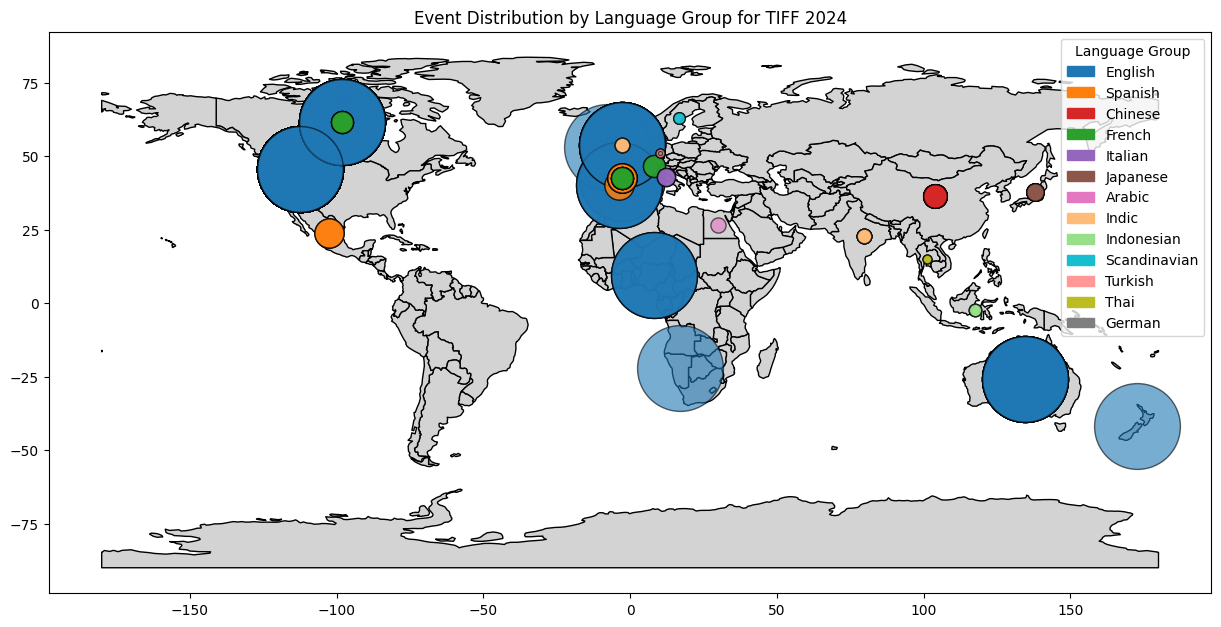

<Figure size 640x480 with 0 Axes>

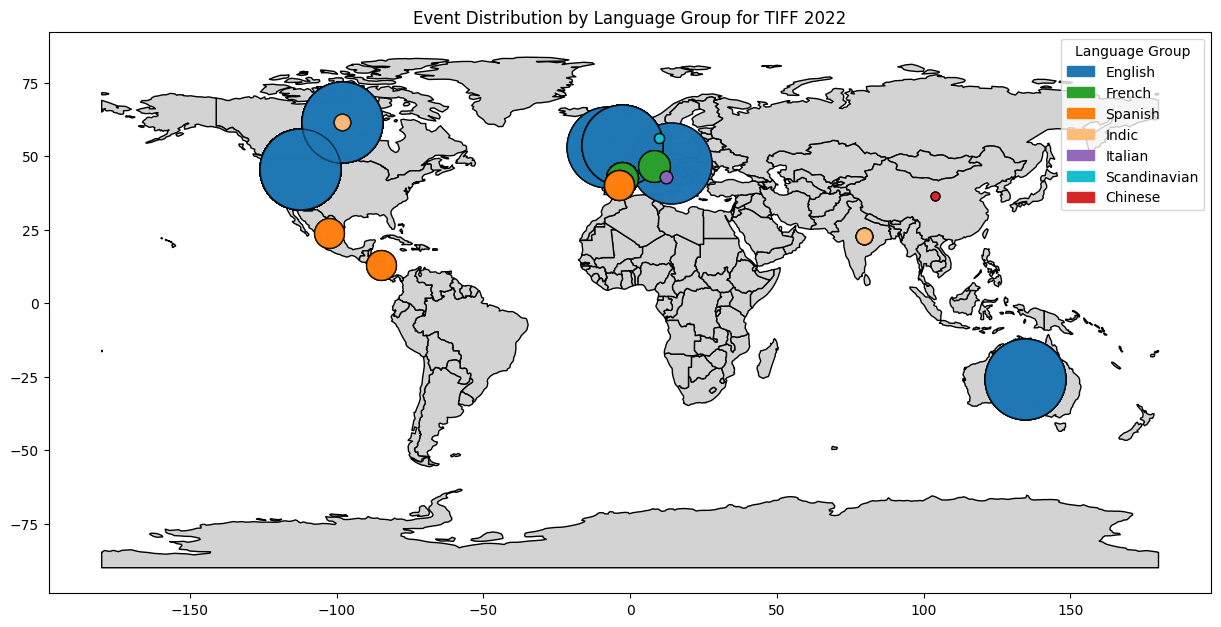

In [53]:
# Plot for TIFF 2024
plot_language_distribution_with_custom_colors(merged_language_group_2024, world, title='Event Distribution by Language Group for TIFF 2024', alpha=0.6)

# Clear the plot before plotting again
plt.clf()

# Plot for TIFF 2022
plot_language_distribution_with_custom_colors(merged_language_group_2022, world, title='Event Distribution by Language Group for TIFF 2022', alpha=0.6)

In [54]:
# Calculates the total number of events, determines the percentage of each language group, and filters out groups with less than the specified threshold of total events

def calculate_and_filter_language_groups(merged_language_group, threshold=0.01):

    """
    Parameters:
    - merged_language_group (DataFrame): The merged data containing language group information.
    - threshold (float): The minimum percentage of total events a language group must have to be included in the filtered data.

    Returns:
    - filtered_data (DataFrame): The filtered data containing language groups above the threshold.
    - sorted_data (DataFrame): The original sorted data with added percentage information.
    """

    # Drop rows with NaN values in the 'Language Group' or 'Number of Events by Language Group' columns
    merged_language_group = merged_language_group.dropna(subset=['Language Group', 'Number of Events by Language Group'])

    # Group by Language Group and aggregate the counts
    grouped = merged_language_group.groupby('Language Group').agg({
        'Number of Events by Language Group': 'sum'
    }).reset_index()

    # Calculate the total number of events
    total_events = grouped['Number of Events by Language Group'].sum()

    # Calculate the percentage of each language group
    grouped['Percentage'] = (grouped['Number of Events by Language Group'] / total_events) * 100

    # Filter out languages with less than the threshold percentage of total events
    filtered_data = grouped[grouped['Percentage'] >= threshold]

    # Check the filtered data
    print(filtered_data[['Language Group', 'Number of Events by Language Group', 'Percentage']])

    return grouped, filtered_data

In [55]:
# Apply to TIFF 2024
grouped_2024, filtered_data_2024 = calculate_and_filter_language_groups(merged_language_group_2024, threshold=0.01)

# Apply to TIFF 2022
grouped_2022, filtered_data_2022 = calculate_and_filter_language_groups(merged_language_group_2022, threshold=0.01)

   Language Group  Number of Events by Language Group  Percentage
0          Arabic                                12.0    0.010214
1         Chinese                               319.0    0.271522
2         English                            115746.0   98.518972
3          French                               450.0    0.383024
5           Indic                               121.0    0.102991
6      Indonesian                                32.0    0.027237
7         Italian                                68.0    0.057879
8        Japanese                               112.0    0.095331
9    Scandinavian                                21.0    0.017874
10        Spanish                               572.0    0.486867
11           Thai                                16.0    0.013619
12        Turkish                                16.0    0.013619
  Language Group  Number of Events by Language Group  Percentage
0        Chinese                                16.0    0.017251
1        Eng

In [56]:
def prepare_filtered_data(merged_language_group):
    # Ensure the data contains only rows with valid geometry
    merged_language_group = merged_language_group[merged_language_group['geometry'].notna()]

    # Calculate the total number of events
    total_events = merged_language_group['Number of Events by Language Group'].sum()

    # Calculate the percentage of each language group
    merged_language_group['Percentage'] = (merged_language_group['Number of Events by Language Group'] / total_events) * 100

    # Filter out languages with less than 0.1% of total events
    filtered_data = merged_language_group[merged_language_group['Percentage'] >= 0.01]

    return filtered_data

In [57]:
# Sort the filtered data by 'Number of Events by Language Group' to ensure smaller circles are plotted last

def plot_filtered_language_distribution(filtered_data, world, title='Event Distribution by Language Group'):
    filtered_data = filtered_data.sort_values(by='Number of Events by Language Group', ascending=False)

    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    world.plot(ax=ax, color='lightgray', edgecolor='black')

    unique_groups = filtered_data['Language Group'].dropna().unique()
    cmap = plt.colormaps['Set1']  # Get the colormap
    color_mapping = dict(zip(unique_groups, cmap.colors[:len(unique_groups)]))  # Use only as many colors as needed

    for idx, row in filtered_data.iterrows():
        ax.scatter(row.geometry.centroid.x, row.geometry.centroid.y,
                   s=row['Number of Events by Language Group'] * 10,
                   color=color_mapping[row['Language Group']],
                   alpha=0.6, edgecolor='k', zorder=2)

    legend_labels = [mpatches.Patch(color=color_mapping[group], label=group) for group in unique_groups]
    plt.legend(handles=legend_labels, title="Language Group", bbox_to_anchor=(1, 1))

    plt.title(title)
    plt.show()
    plt.close(fig)  # Close the figure to prevent extra plots

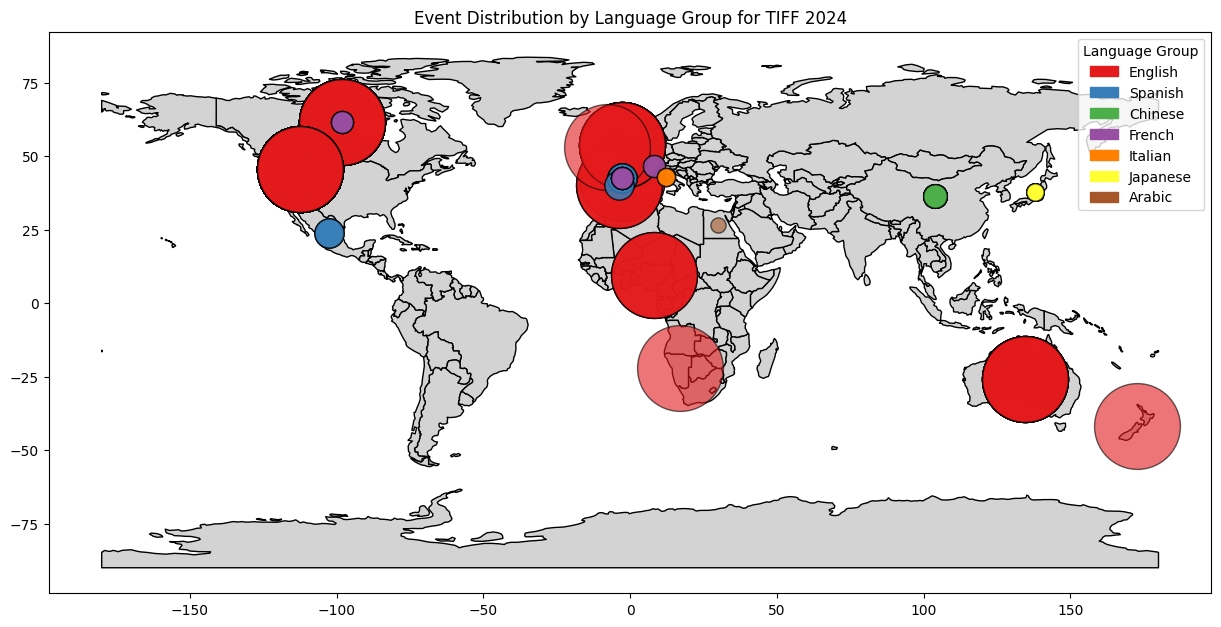

<Figure size 640x480 with 0 Axes>

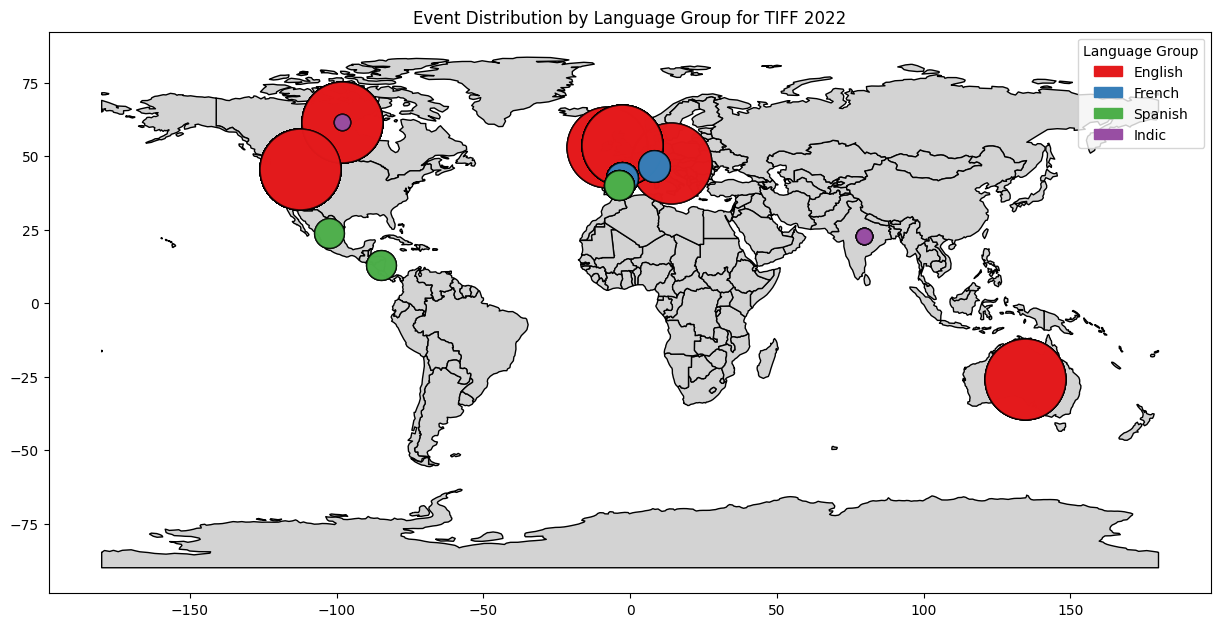

In [58]:
# Prepare and filter the data for both TIFF 2024 and TIFF 2022
filtered_data_2024 = prepare_filtered_data(merged_language_group_2024)
filtered_data_2022 = prepare_filtered_data(merged_language_group_2022)

# Plot for TIFF 2024
plot_filtered_language_distribution(filtered_data_2024, world, title='Event Distribution by Language Group for TIFF 2024')

# Clear the plot before plotting again
plt.clf()

# Plot for TIFF 2022
plot_filtered_language_distribution(filtered_data_2022, world, title='Event Distribution by Language Group for TIFF 2022')

In [59]:
def plot_language_distribution_with_seaborn_palette(sorted_data, world, title='Event Distribution by Language Group'):
    # Sort the data to ensure smaller circles are plotted last
    sorted_data = sorted_data.sort_values(by='Number of Events by Language Group', ascending=False)

    # Generate the color palette
    unique_groups = sorted_data['Language Group'].dropna().unique()  # Ensure all groups are captured
    palette = sns.color_palette("husl", len(unique_groups))  # Generate enough colors for all groups
    color_mapping = dict(zip(unique_groups, palette))  # Map colors to each group

    # Plot the data by language groups
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    world.plot(ax=ax, color='lightgray', edgecolor='black')

    # Iterating over the sorted data to plot circles
    for idx, row in sorted_data.iterrows():
        # Safely access the color mapping with a default color if a group is missing
        color = color_mapping.get(row['Language Group'], '#7f7f7f')  # Default to grey if group not found
        ax.scatter(row.geometry.centroid.x, row.geometry.centroid.y,
                   s=row['Number of Events by Language Group'] * 10,
                   color=color,
                   alpha=0.4, edgecolor='k', zorder=2)

    # Creating a legend
    legend_labels = [mpatches.Patch(color=color_mapping[group], label=group) for group in unique_groups]
    plt.legend(handles=legend_labels, title="Language Group", bbox_to_anchor=(1, 1))

    plt.title(title)
    plt.show()
    plt.close(fig)  # Close the figure to prevent extra plots

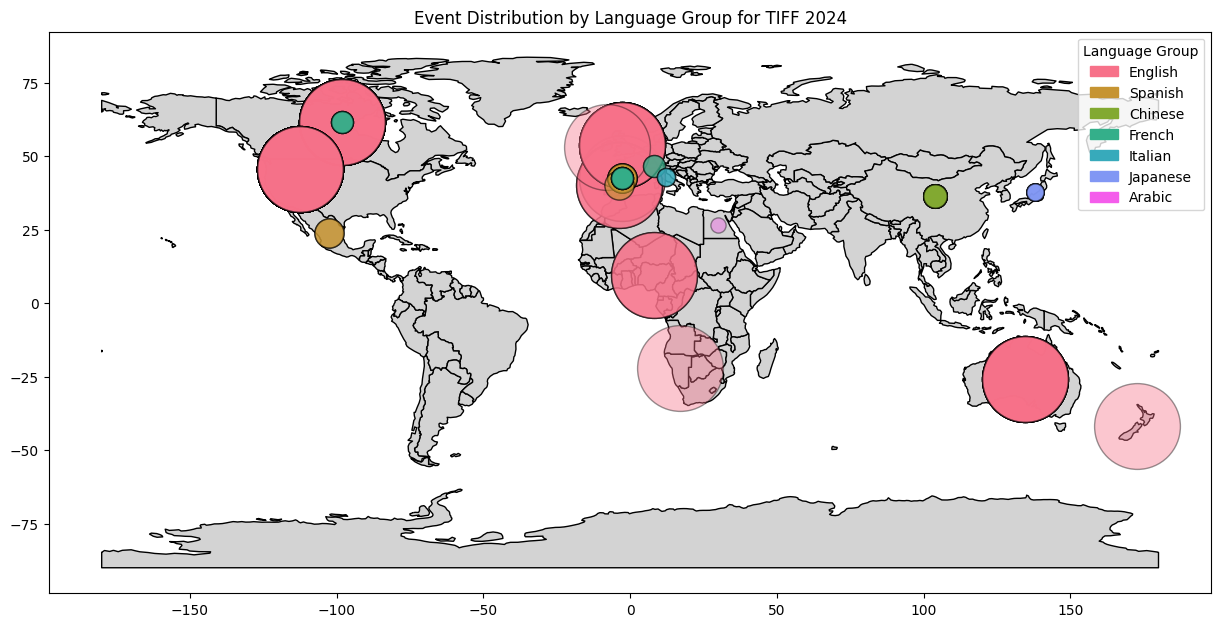

<Figure size 640x480 with 0 Axes>

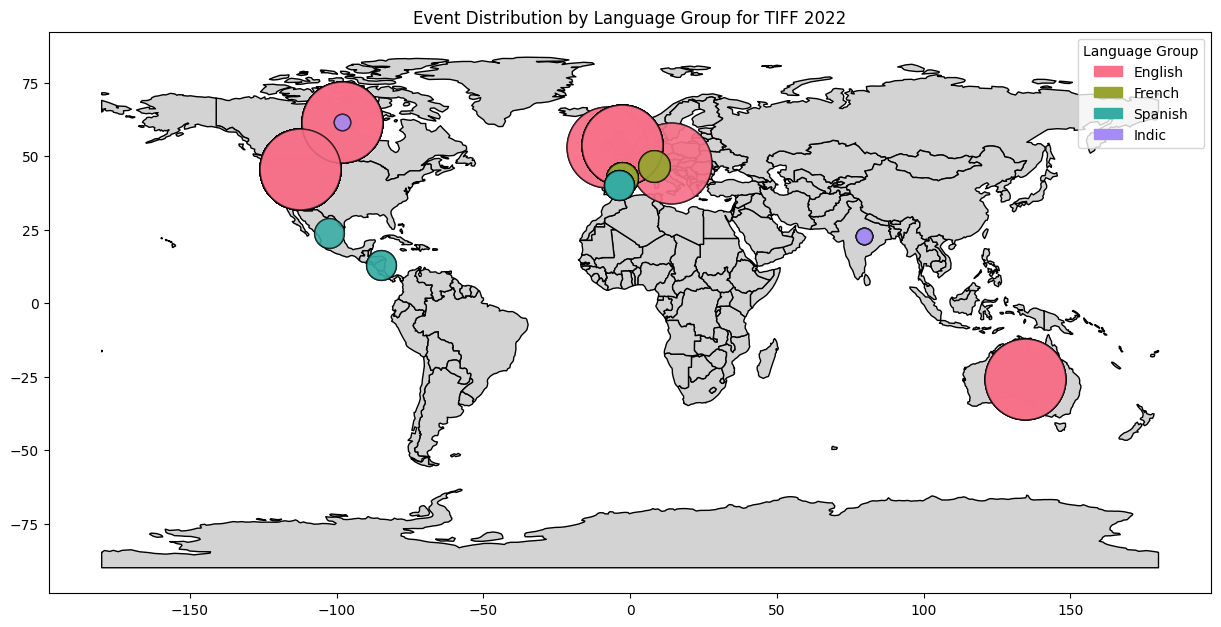

In [60]:
# Ensure you have sorted and prepared data for both TIFF 2024 and TIFF 2022
sorted_data_2024 = prepare_filtered_data(merged_language_group_2024)
sorted_data_2022 = prepare_filtered_data(merged_language_group_2022)

# Plot for TIFF 2024
plot_language_distribution_with_seaborn_palette(sorted_data_2024, world, title='Event Distribution by Language Group for TIFF 2024')

# Clear the plot before plotting again
plt.clf()

# Plot for TIFF 2022
plot_language_distribution_with_seaborn_palette(sorted_data_2022, world, title='Event Distribution by Language Group for TIFF 2022')

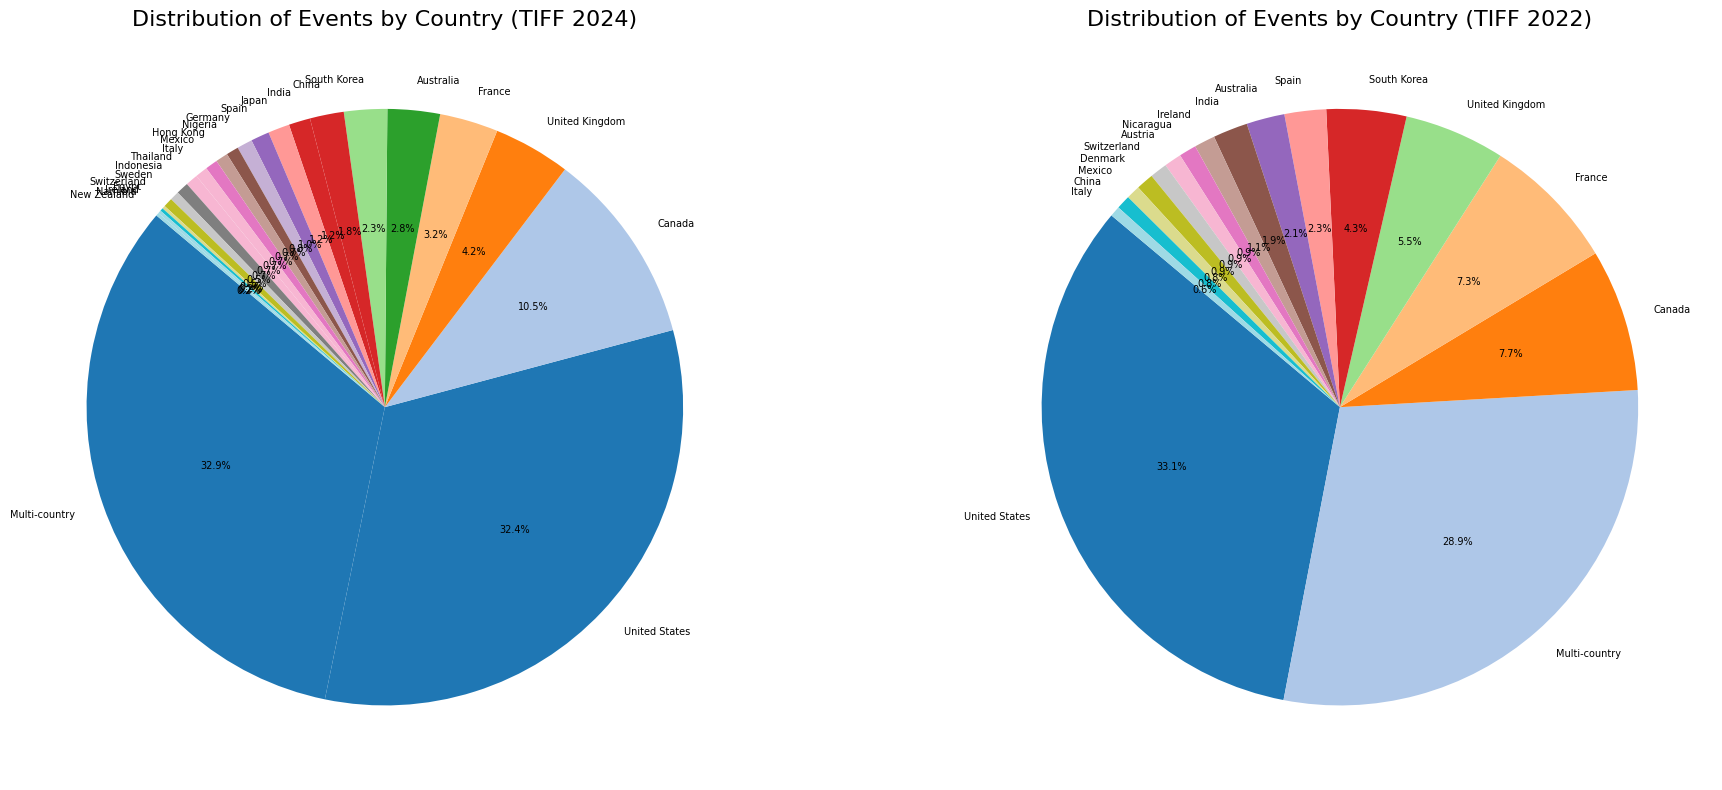

In [65]:
# Create a figure with two subplots in a single row
fig, axes = plt.subplots(1, 2, figsize=(20, 8))  # 1 row, 2 columns

# Pie chart for TIFF 2024
country_distribution_2024 = tiff_2024['Countries'].value_counts()
country_distribution_2024.plot.pie(ax=axes[0], autopct='%1.1f%%', startangle=140, cmap='tab20', fontsize=7)  # Adjust fontsize
axes[0].set_title('Distribution of Events by Country (TIFF 2024)', fontsize=16)  # Adjust title font size
axes[0].set_ylabel('')  # Remove y-axis label

# Pie chart for TIFF 2022
country_distribution_2022 = tiff_2022['Countries'].value_counts()
country_distribution_2022.plot.pie(ax=axes[1], autopct='%1.1f%%', startangle=140, cmap='tab20', fontsize=7)  # Adjust fontsize
axes[1].set_title('Distribution of Events by Country (TIFF 2022)', fontsize=16)  # Adjust title font size
axes[1].set_ylabel('')  # Remove y-axis label

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()

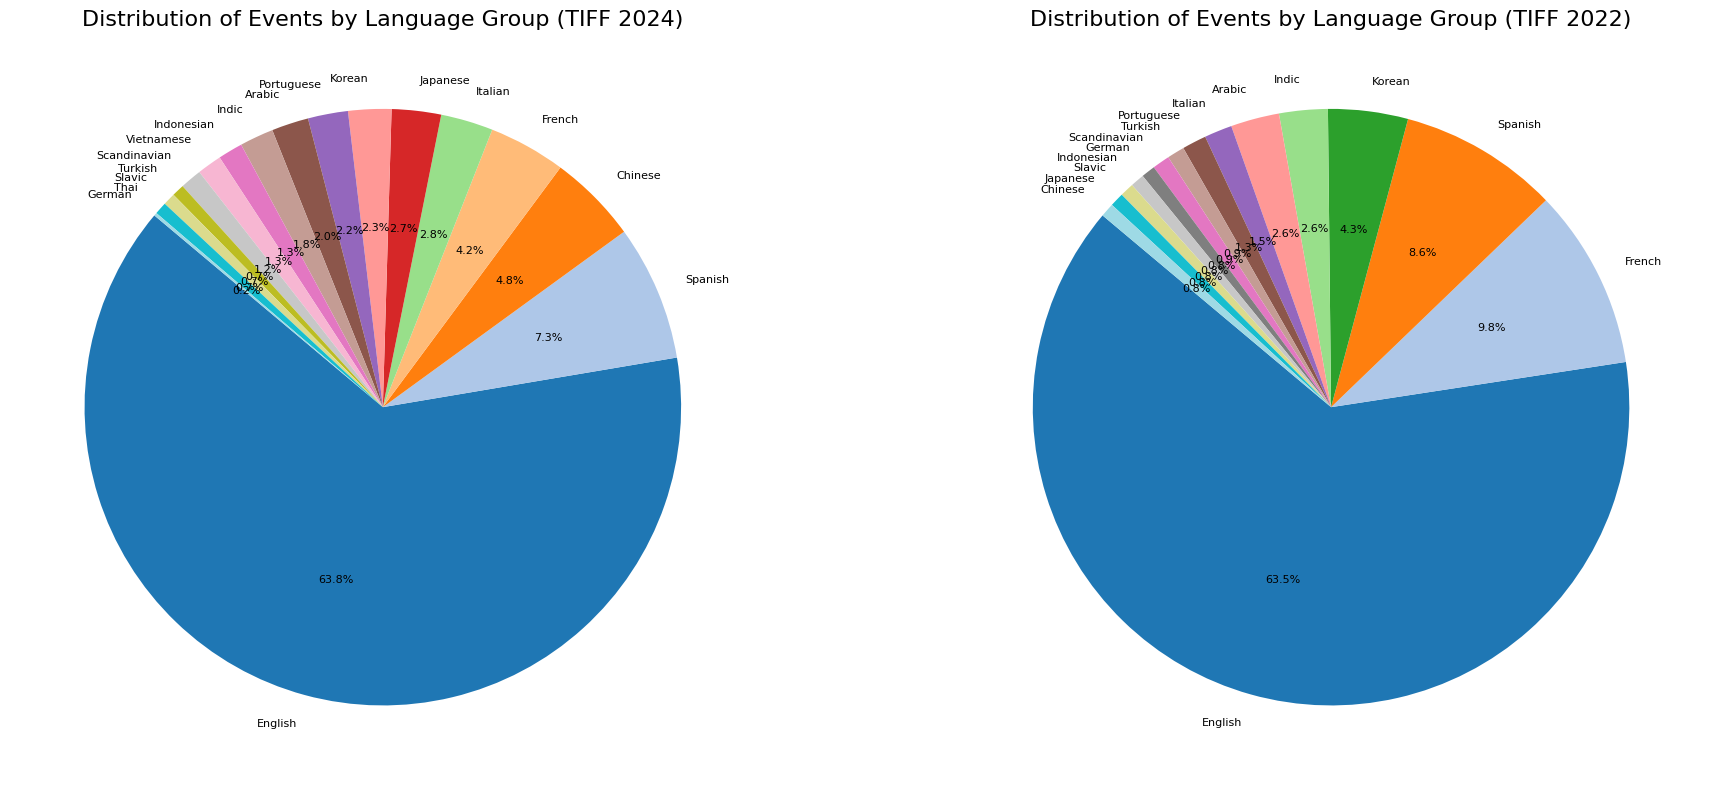

In [67]:
# Create a figure with two subplots in a single row
fig, axes = plt.subplots(1, 2, figsize=(20, 8))  # 1 row, 2 columns

# Pie chart for Language Distribution in TIFF 2024
language_distribution_2024 = tiff_2024['Language Group'].value_counts()
language_distribution_2024.plot.pie(ax=axes[0], autopct='%1.1f%%', startangle=140, cmap='tab20', fontsize=8)  # Adjust fontsize
axes[0].set_title('Distribution of Events by Language Group (TIFF 2024)', fontsize=16)  # Adjust title font size
axes[0].set_ylabel('')  # Remove y-axis label

# Pie chart for Language Distribution in TIFF 2022
language_distribution_2022 = tiff_2022['Language Group'].value_counts()
language_distribution_2022.plot.pie(ax=axes[1], autopct='%1.1f%%', startangle=140, cmap='tab20', fontsize=8)  # Adjust fontsize
axes[1].set_title('Distribution of Events by Language Group (TIFF 2022)', fontsize=16)  # Adjust title font size
axes[1].set_ylabel('')  # Remove y-axis label

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()

<Figure size 1200x800 with 0 Axes>

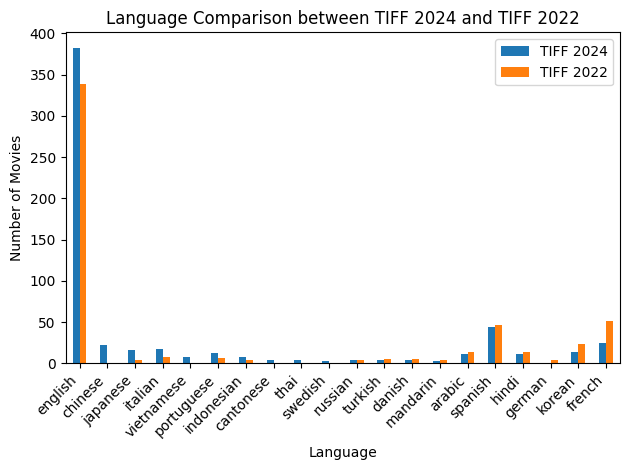

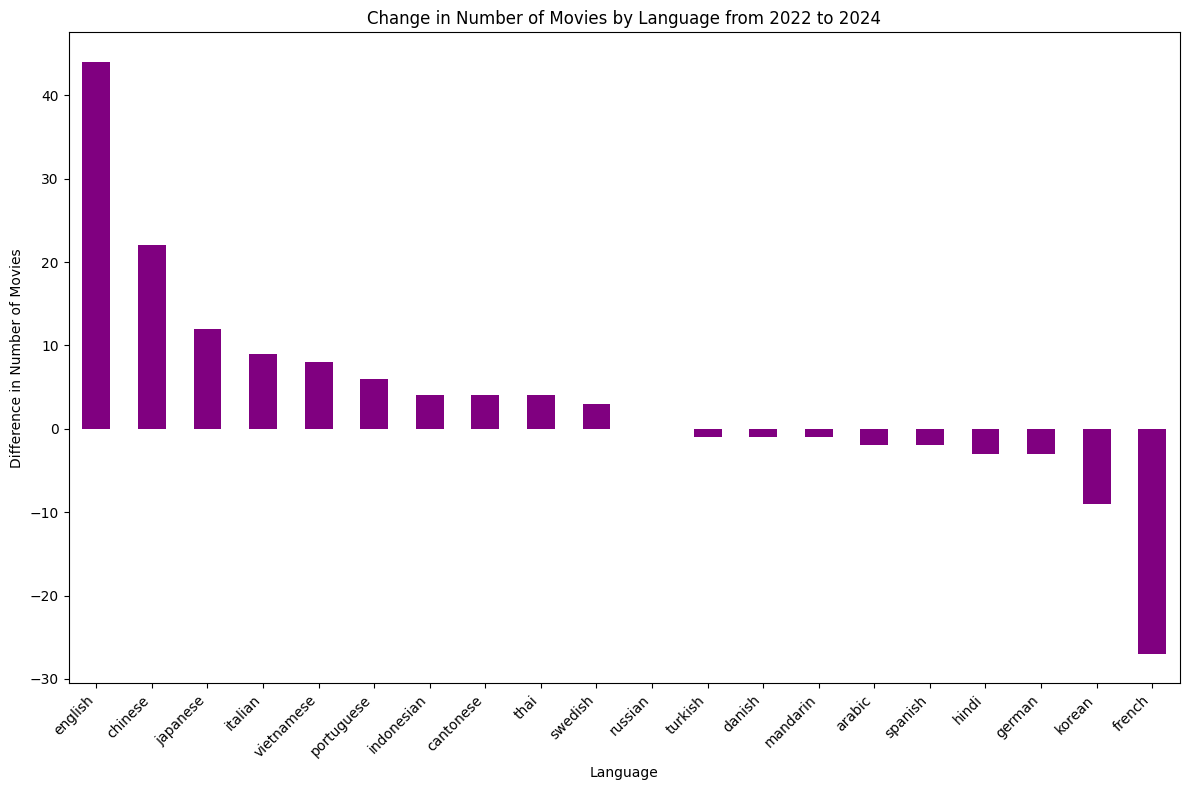

In [68]:
# Step 1: Count the number of films for each language in 2024 and 2022
language_counts_2024 = tiff_2024['Languages'].value_counts().rename('TIFF 2024')
language_counts_2022 = tiff_2022['Languages'].value_counts().rename('TIFF 2022')

# Step 2: Combine the language counts into a single DataFrame
language_comparison = pd.concat([language_counts_2024, language_counts_2022], axis=1).fillna(0)

# Step 3: Calculate the difference between 2024 and 2022
language_comparison['Difference'] = language_comparison['TIFF 2024'] - language_comparison['TIFF 2022']

# Step 4: Sort the DataFrame by the difference to see which languages increased or decreased
language_comparison_sorted = language_comparison.sort_values('Difference', ascending=False)

# Step 5: Plot the comparison
plt.figure(figsize=(12, 8))
language_comparison_sorted[['TIFF 2024', 'TIFF 2022']].plot(kind='bar', stacked=False, color=['#1f77b4', '#ff7f0e'])
plt.title('Language Comparison between TIFF 2024 and TIFF 2022')
plt.ylabel('Number of Movies')
plt.xlabel('Language')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Step 6: Plot the differences
plt.figure(figsize=(12, 8))
language_comparison_sorted['Difference'].plot(kind='bar', color='purple')
plt.title('Change in Number of Movies by Language from 2022 to 2024')
plt.ylabel('Difference in Number of Movies')
plt.xlabel('Language')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

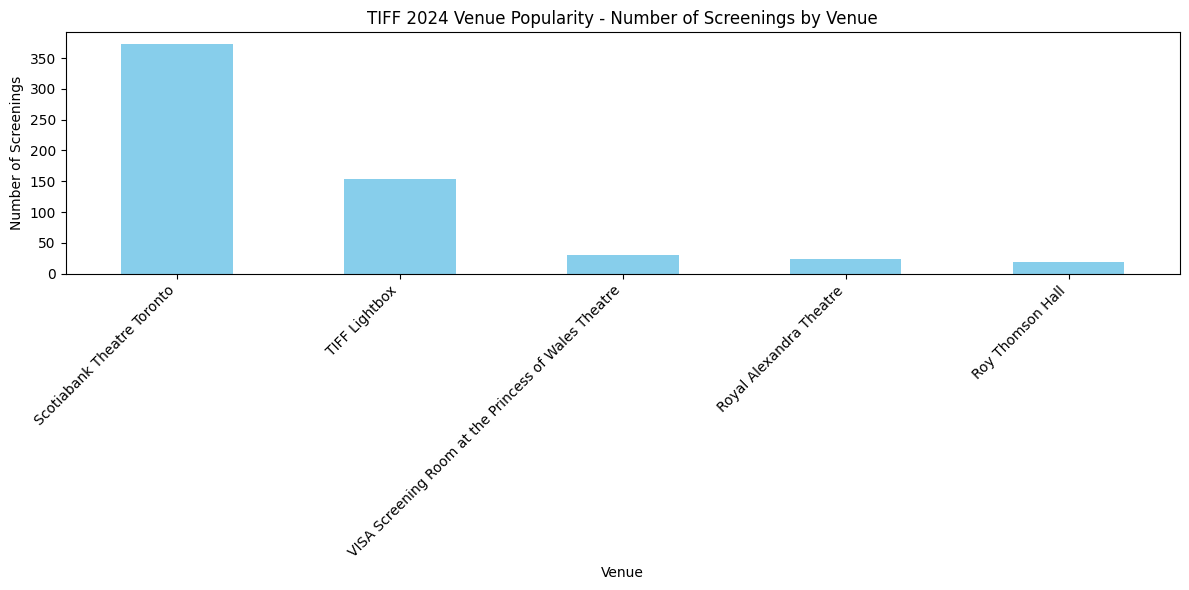

In [69]:
# Analyzing which venues are hosting the most screenings
venue_popularity = tiff_2024['Venue'].value_counts()

# Plot the distribution of screenings by venue
plt.figure(figsize=(12, 6))
venue_popularity.plot(kind='bar', color='skyblue')
plt.title('TIFF 2024 Venue Popularity - Number of Screenings by Venue')
plt.xlabel('Venue')
plt.ylabel('Number of Screenings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

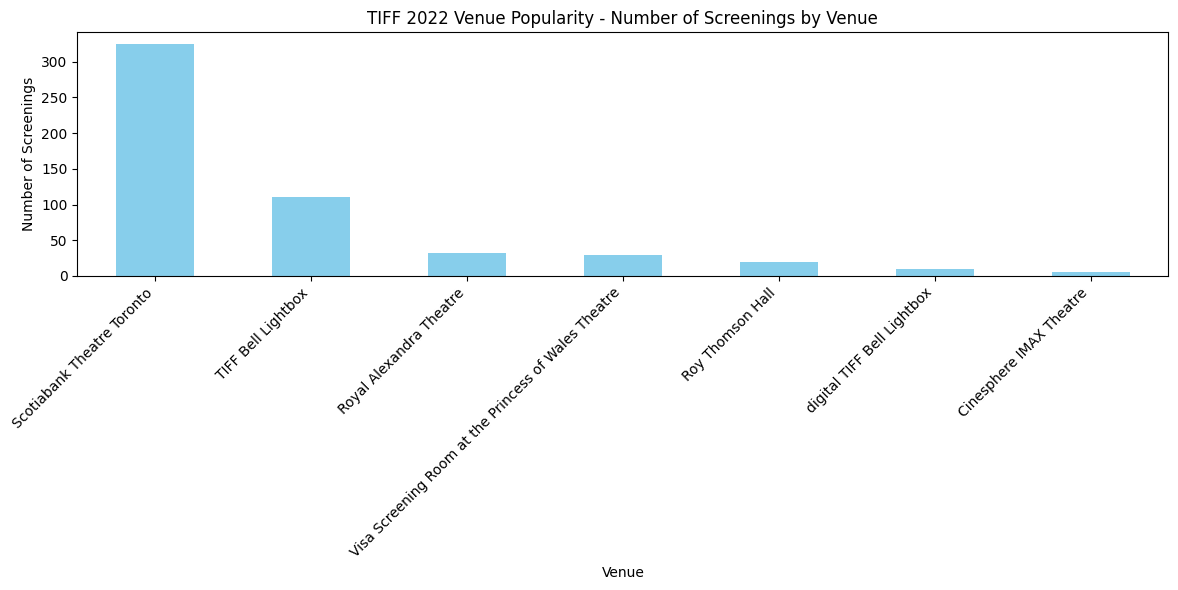

In [70]:
# Analyzing which venues are hosting the most screenings
venue_popularity = tiff_2022['Venue'].value_counts()

# Plot the distribution of screenings by venue
plt.figure(figsize=(12, 6))
venue_popularity.plot(kind='bar', color='skyblue')
plt.title('TIFF 2022 Venue Popularity - Number of Screenings by Venue')
plt.xlabel('Venue')
plt.ylabel('Number of Screenings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

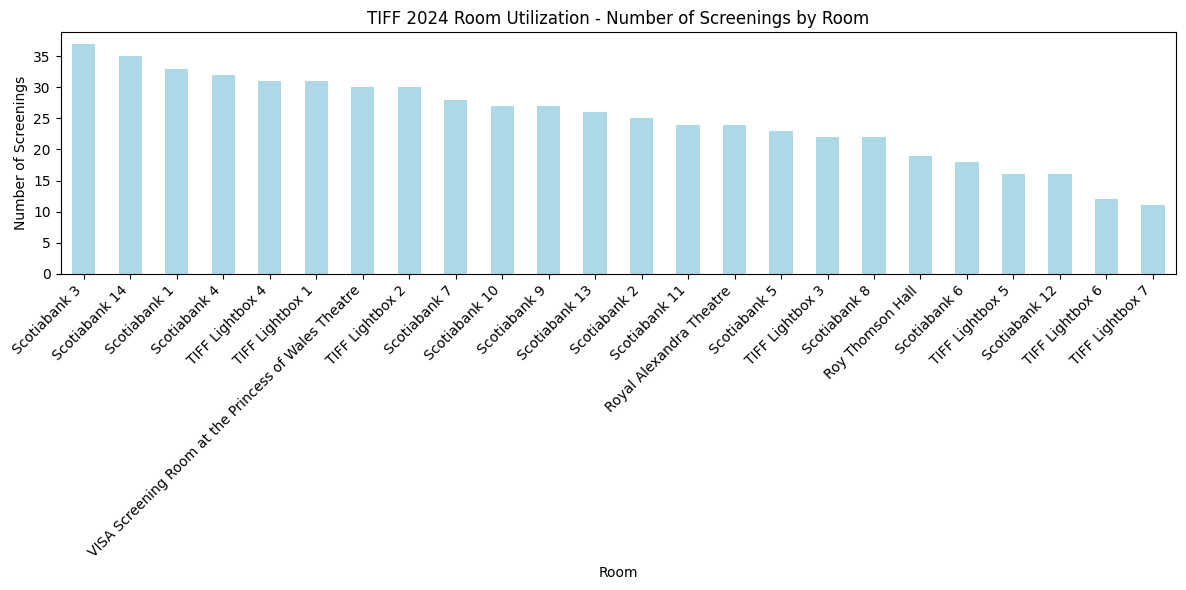

Percentage of screenings in the top 5 most frequent rooms: 28.05%


In [71]:
# Analyzing room utilization across the festival
room_utilization = tiff_2024['Room'].value_counts()

# Determine the top N most frequent room numbers (e.g., top 5)
top_n = 5
top_rooms = room_utilization.head(top_n)

# Calculate the total number of screenings in the top N rooms
total_top_rooms = top_rooms.sum()

# Calculate the total number of screenings across all rooms
total_screenings = room_utilization.sum()

# Calculate the percentage of screenings in the top N rooms
percentage_top_rooms = (total_top_rooms / total_screenings) * 100

# Plotting room utilization
plt.figure(figsize=(12, 6))
room_utilization.plot(kind='bar', color='lightblue')
plt.title('TIFF 2024 Room Utilization - Number of Screenings by Room')
plt.xlabel('Room')
plt.ylabel('Number of Screenings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Output the percentage of screenings in the top N most frequent rooms
print(f"Percentage of screenings in the top {top_n} most frequent rooms: {percentage_top_rooms:.2f}%")

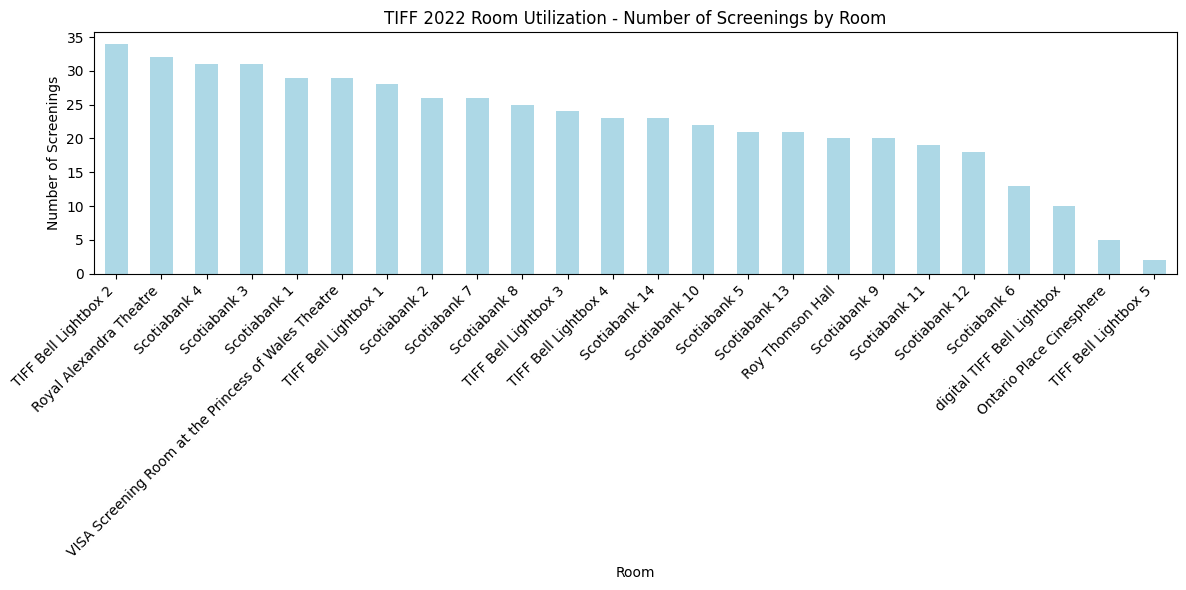

Percentage of screenings in the top 5 most frequent rooms: 29.51%


In [72]:
# Analyzing room utilization across the festival
room_utilization = tiff_2022['Room'].value_counts()

# Determine the top N most frequent room numbers (e.g., top 5)
top_n = 5
top_rooms = room_utilization.head(top_n)

# Calculate the total number of screenings in the top N rooms
total_top_rooms = top_rooms.sum()

# Calculate the total number of screenings across all rooms
total_screenings = room_utilization.sum()

# Calculate the percentage of screenings in the top N rooms
percentage_top_rooms = (total_top_rooms / total_screenings) * 100

# Plotting room utilization
plt.figure(figsize=(12, 6))
room_utilization.plot(kind='bar', color='lightblue')
plt.title('TIFF 2022 Room Utilization - Number of Screenings by Room')
plt.xlabel('Room')
plt.ylabel('Number of Screenings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Output the percentage of screenings in the top N most frequent rooms
print(f"Percentage of screenings in the top {top_n} most frequent rooms: {percentage_top_rooms:.2f}%")

In [73]:
# Count the occurrences of each audience type
audience_type_counts = tiff_2024['Audience Type'].value_counts()

# Display the counts
print("TIFF 2024 - ", audience_type_counts)

TIFF 2024 -  Audience Type
General Public                                                                                      391
Buyers Pass,Industry Pass,Film Rep Pass,Premium Industry Pass,Conference Pass,Guest,Press Passes    165
Buyers Pass                                                                                          24
Buyers Pass,Industry Pass,Film Rep Pass,Premium Industry Pass,Conference Pass,Guest                  19
Name: count, dtype: int64


In [74]:
# Count the occurrences of each audience type
audience_type_counts = tiff_2022['Audience Type'].value_counts()

# Display the counts
print("TIFF 2022 - ", audience_type_counts)

TIFF 2022 -  Audience Type
General Public                             353
Buyers Pass,Pro Pass,Guest,Press Passes    179
Name: count, dtype: int64


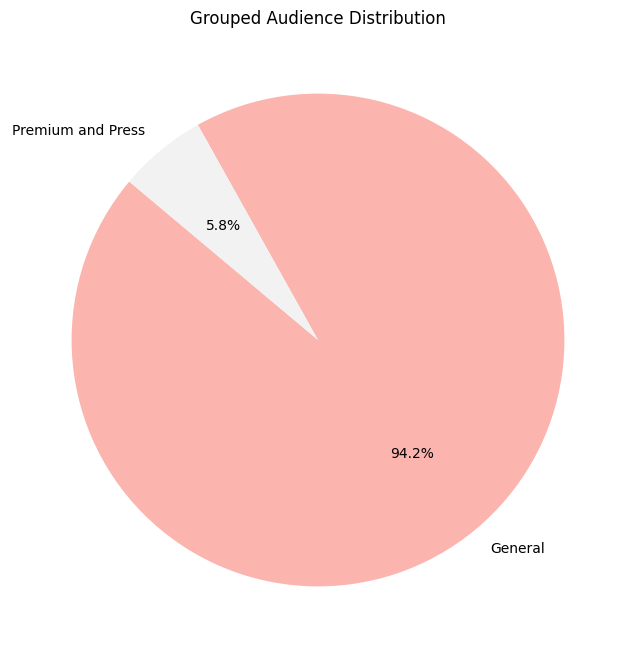

In [75]:
# Step 1: Define the mapping of Audience Types to the new categories
audience_mapping = {
    'General Public': 'General',
    'Buyers Pass': 'Premium and Press',
    'Industry Pass': 'Premium and Press',
    'Film Rep Pass': 'Premium and Press',
    'Premium Industry Pass': 'Premium and Press',
    'Conference Pass': 'Premium and Press',
    'Guest': 'Premium and Press',
    'Press Passes': 'Premium and Press',
}

# Step 2: Apply the mapping to create a new column for grouped audience types
tiff_2024['Grouped Audience Type'] = tiff_2024['Audience Type'].map(audience_mapping)

# Step 3: Analyze the distribution of grouped audience types
grouped_audience_distribution = tiff_2024['Grouped Audience Type'].value_counts()

# Step 4: Plot the distribution with a pie chart
plt.figure(figsize=(8, 8))
grouped_audience_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=140, cmap='Pastel1')
plt.title('Grouped Audience Distribution')
plt.ylabel('')  # Hides the y-axis label
plt.show()

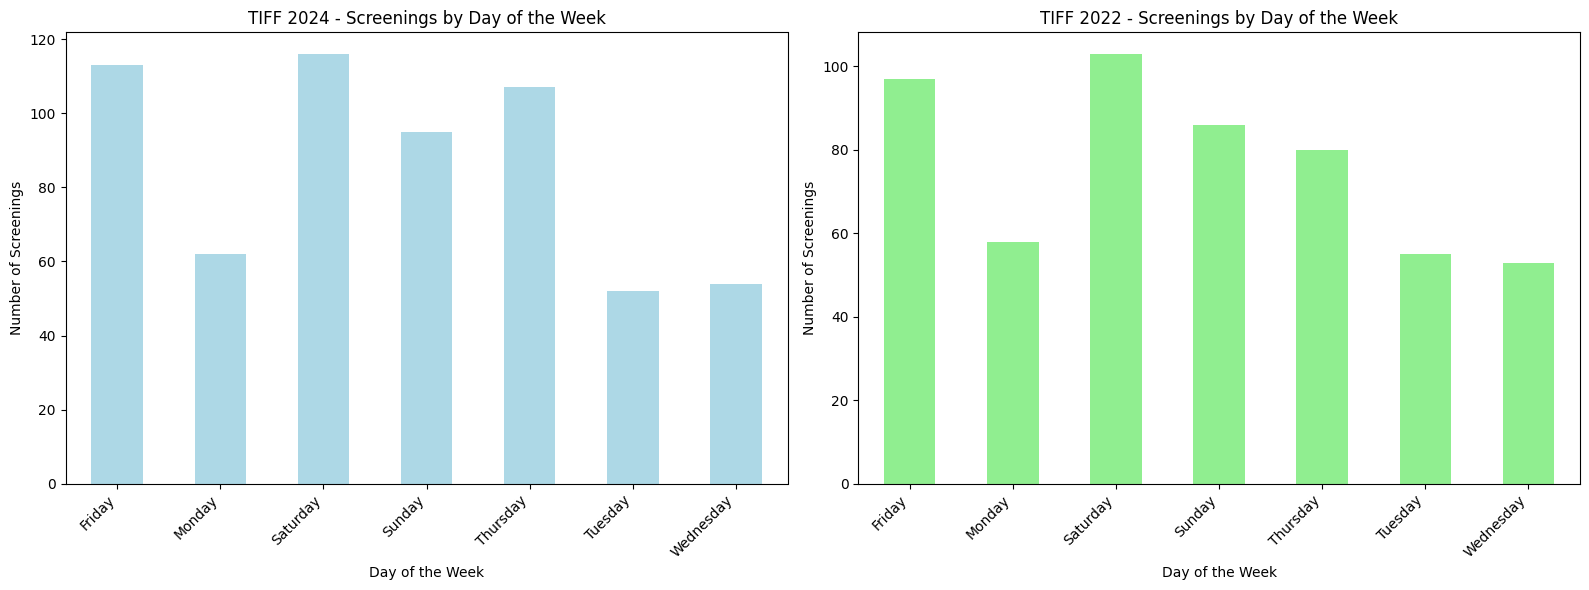

In [76]:
# Ensure 'Day of Week' column exists for both datasets
tiff_2024['Day of Week'] = tiff_2024['Date'].dt.day_name()
tiff_2022['Day of Week'] = tiff_2022['Date'].dt.day_name()

# Group by Day of Week and count the number of screenings for TIFF 2024
day_of_week_distribution_2024 = tiff_2024.groupby(['Day of Week']).size()

# Group by Day of Week and count the number of screenings for TIFF 2022
day_of_week_distribution_2022 = tiff_2022.groupby(['Day of Week']).size()

# Create a figure with two subplots in a single row
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot for TIFF 2024
day_of_week_distribution_2024.plot(kind='bar', color='lightblue', ax=axes[0])
axes[0].set_title('TIFF 2024 - Screenings by Day of the Week')
axes[0].set_xlabel('Day of the Week')
axes[0].set_ylabel('Number of Screenings')
axes[0].set_xticklabels(day_of_week_distribution_2024.index, rotation=45, ha='right')

# Plot for TIFF 2022
day_of_week_distribution_2022.plot(kind='bar', color='lightgreen', ax=axes[1])
axes[1].set_title('TIFF 2022 - Screenings by Day of the Week')
axes[1].set_xlabel('Day of the Week')
axes[1].set_ylabel('Number of Screenings')
axes[1].set_xticklabels(day_of_week_distribution_2022.index, rotation=45, ha='right')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

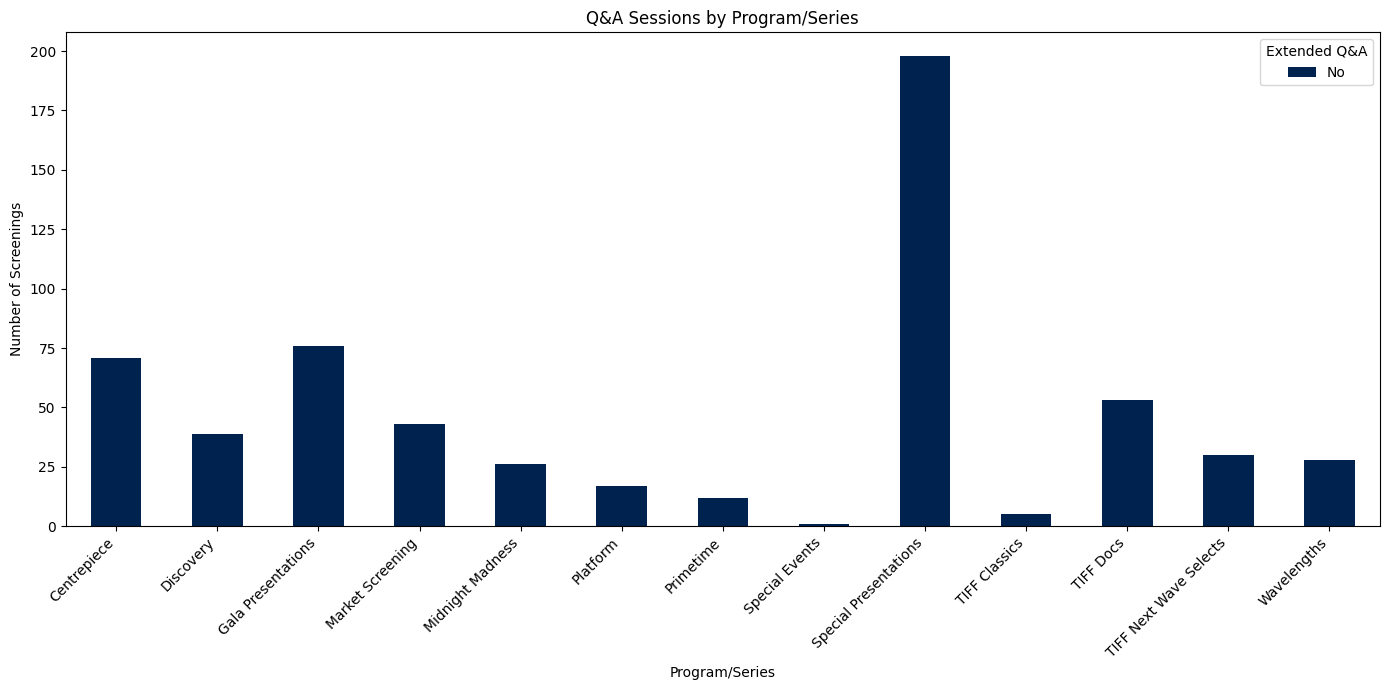

In [77]:
# Analyze the distribution of Q&A sessions across different genres or programs
qna_by_program = tiff_2024.groupby(['Programme or Series', 'Extended Q&A']).size().unstack().fillna(0)

# Plot the distribution
plt.figure(figsize=(14, 7))
qna_by_program.plot(kind='bar', stacked=True, colormap='cividis', ax=plt.gca())
plt.title('Q&A Sessions by Program/Series')
plt.xlabel('Program/Series')
plt.ylabel('Number of Screenings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

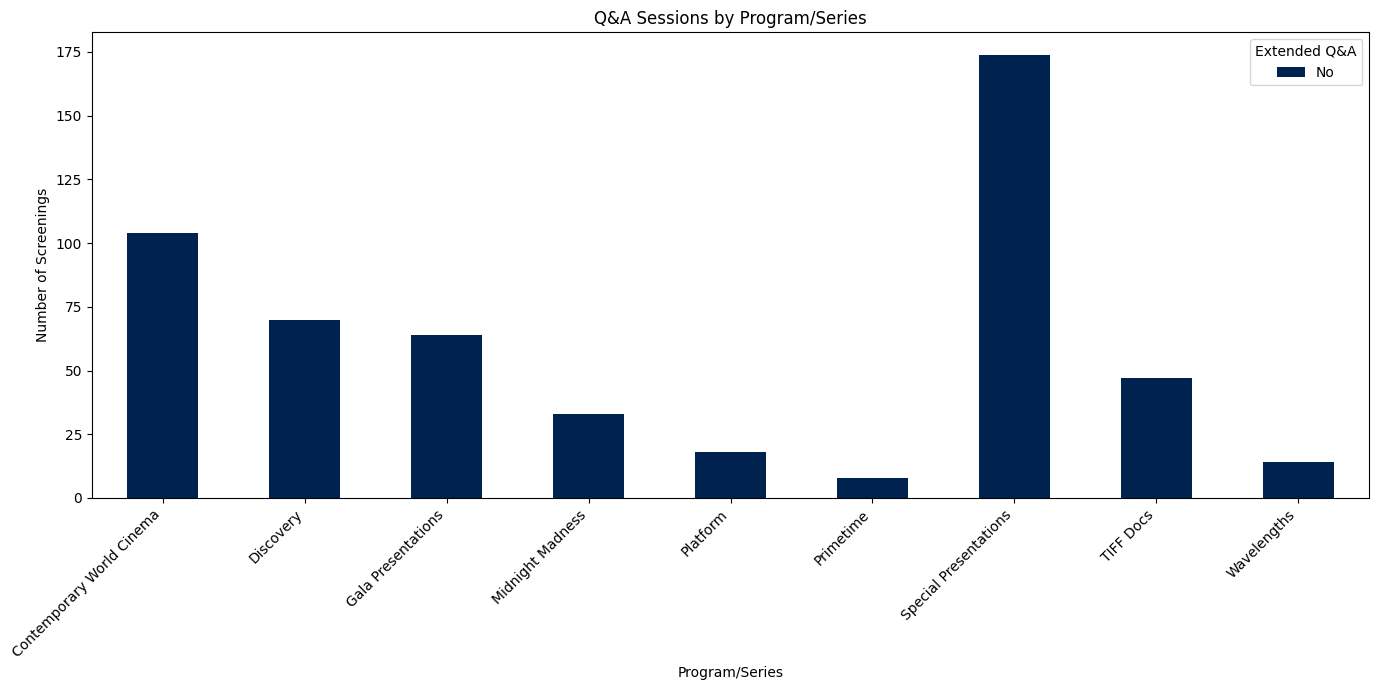

In [78]:
# Analyze the distribution of Q&A sessions across different genres or programs
qna_by_program = tiff_2022.groupby(['Programme or Series', 'Extended Q&A']).size().unstack().fillna(0)

# Plot the distribution
plt.figure(figsize=(14, 7))
qna_by_program.plot(kind='bar', stacked=True, colormap='cividis', ax=plt.gca())
plt.title('Q&A Sessions by Program/Series')
plt.xlabel('Program/Series')
plt.ylabel('Number of Screenings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [79]:
# Check the first few rows of the Countries column
print(tiff_2024[['Title', 'Countries']].head(20))
print(tiff_2022[['Title', 'Countries']].head(20))

                            Title       Countries
12                       Aberdeen          Canada
13                       Aberdeen          Canada
14                       Aberdeen          Canada
15                       Aberdeen          Canada
16                       Addition       Australia
17                       Addition       Australia
18                       Addition       Australia
19                       Addition       Australia
23                     All of You  United Kingdom
24                     All of You  United Kingdom
25                     All of You  United Kingdom
26                     All of You  United Kingdom
27                      Americano   United States
28             An Unfinished Film   Multi-country
29             An Unfinished Film   Multi-country
30             An Unfinished Film   Multi-country
31             An Unfinished Film   Multi-country
32  And Their Children After Them          France
48                    Average Joe   United States


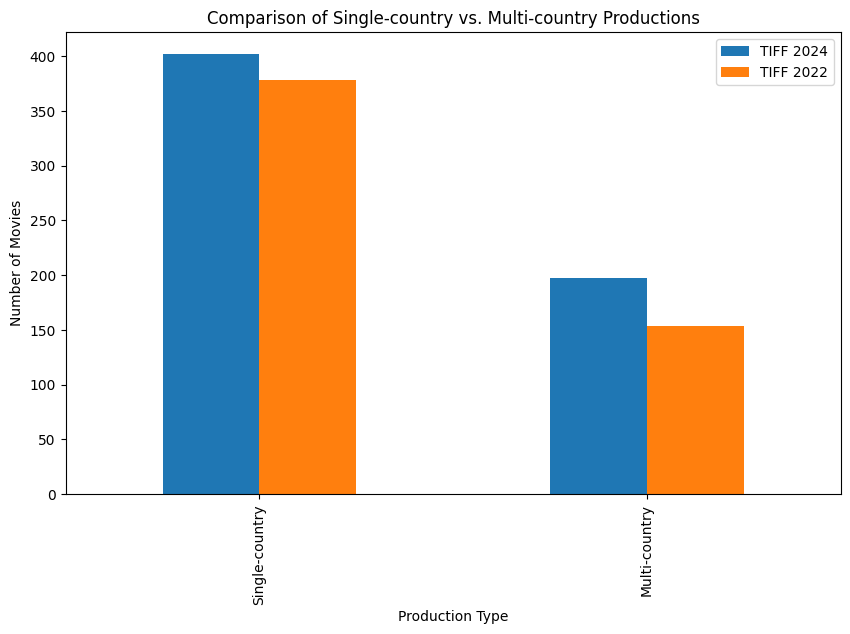

In [80]:
# Reclassify based on the 'Countries' column
def classify_production_type(countries):
    if countries == 'Multi-country':
        return 'Multi-country'
    return 'Single-country'

# Apply the classification to both datasets
tiff_2024['Production Type'] = tiff_2024['Countries'].apply(classify_production_type)
tiff_2022['Production Type'] = tiff_2022['Countries'].apply(classify_production_type)

# Count the number of single-country vs. multi-country productions
production_counts_2024 = tiff_2024['Production Type'].value_counts().rename('TIFF 2024')
production_counts_2022 = tiff_2022['Production Type'].value_counts().rename('TIFF 2022')

# Combine the counts for both years into a single DataFrame
production_comparison = pd.concat([production_counts_2024, production_counts_2022], axis=1)

# Plot the comparison using stacked bar charts
production_comparison.plot(kind='bar', stacked=False, figsize=(10, 6), color=['#1f77b4', '#ff7f0e'])
plt.title('Comparison of Single-country vs. Multi-country Productions')
plt.ylabel('Number of Movies')
plt.xlabel('Production Type')
plt.show()